<a href="https://colab.research.google.com/github/mnishio240/laserscar/blob/main/2/20%E6%9C%80%E6%96%B0%E7%89%88(%E9%87%8D%E3%81%99%E3%81%8E%E3%81%A6%E5%AD%A6%E7%BF%92%E3%81%A7%E3%81%8D%E3%81%AA%E3%81%84).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function, division
# !pip install torch_optimizer

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
import torch
import torch.nn as nn
#import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil
import csv
import pandas as pd
import glob
from PIL import Image
from torch.cuda.amp import autocast, GradScaler


#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

#あればGPUを使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!nvidia-smi -L

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')



GPU 0: Tesla T4 (UUID: GPU-e861ddd1-4cc1-c7c0-cb23-a55e3ccd78fc)
Mounted at /content/drive


In [ ]:
# zip fileを解凍。/content/imagesへ。

import zipfile
zip_parent_path = "/content/drive/MyDrive/Deep_learning/PCAF_AI_Project/Cropped_images"
zip_name = ["Patient_1_Cropped.zip", "Patient13R_Cropped.zip"]
extract_path = "/content/images"

for zip_file in zip_name:
  zip_file_path = os.path.join(zip_parent_path, zip_file)
  try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)
    print(f"Successfully extracted {zip_file} to {extract_path}")
  except FileNotFoundError:
    print(f"Error: {zip_file} not found at {zip_file_path}")
  except zipfile.BadZipFile:
    print(f"Error: {zip_file} is not a valid zip file.")
  except Exception as e:
    print(f"An unexpected error occurred while extracting {zip_file}: {e}")


Error: Patient_1_Cropped.zip not found at /content/drive/MyDrive/Deep_learning/PCAF_AI_Project/Cropped_images/Patient_1_Cropped.zip
Error: Patient13R_Cropped.zip not found at /content/drive/MyDrive/Deep_learning/PCAF_AI_Project/Cropped_images/Patient13R_Cropped.zip


In [ ]:
csv_path = "/content/drive/MyDrive/Pixel_Comparison2Y3MPatient13R_Tracks_1_to_1010.csv"
cropped_img_dir = "/content/drive/MyDrive/Patient13R_Cropped"

#Patientとphaseを指定して画像を抜き出し
first_characters = "Pt13R_2_0M"

df = pd.read_csv(csv_path)
filtered_df = df[df["File Prefix1"].str.startswith(first_characters)]

filtered_df.head()

,Track Number,File Prefix1,File Prefix2,Pixels Prefix1,Pixels Prefix2,Ratio
0,1,Pt13R_2_0MPhoto_label0_track1.png,Pt13R_7_2Y3MPhoto_label0_track1.png,529,255,0.482042
1,2,Pt13R_2_0MPhoto_label0_track2.png,Pt13R_7_2Y3MPhoto_label0_track2.png,483,648,1.341615
2,3,Pt13R_2_0MPhoto_label0_track3.png,Pt13R_7_2Y3MPhoto_label0_track3.png,441,340,0.770975
3,4,Pt13R_2_0MPhoto_label0_track4.png,Pt13R_7_2Y3MPhoto_label0_track4.png,418,408,0.976077
4,5,Pt13R_2_0MPhoto_label0_track5.png,Pt13R_7_2Y3MPhoto_label0_track5.png,506,224,0.442688


In [ ]:
import os
import pandas as pd
import glob
from sklearn.model_selection import train_test_split

def load_and_filter_data(csv_paths, cropped_img_dirs, first_characters_list):
    """
    指定されたCSVファイルを読み込み、first_charactersに一致するデータを取得。
    """
    all_data = []

    for csv_path, img_dir, first_characters in zip(csv_paths, cropped_img_dirs, first_characters_list):
        # CSVを読み込む
        df = pd.read_csv(csv_path)

        # 指定の文字列でフィルタリング
        filtered_df = df[df["File Prefix1"].str.startswith(first_characters)]

        # 画像のパスを取得
        filtered_df["Image Path"] = filtered_df["File Prefix1"].apply(lambda x: glob.glob(os.path.join(img_dir, x + "*.png")))

        all_data.append(filtered_df)

    # すべてのデータを結合
    final_df = pd.concat(all_data, ignore_index=True)
    return final_df

# 指定するCSVファイルと対応する画像フォルダ、フィルタリング条件
csv_paths = [
    "/content/drive/MyDrive/Pixel_Comparison2YearsPatient1_Tracks_1_to_1004.csv",
    "/content/drive/MyDrive/Pixel_Comparison2Y3MPatient13R_Tracks_1_to_1010.csv",
    "/content/drive/MyDrive/Pixel_Comparison_Patient21R_0MPhoto_1Y3MPhoto.csv"
]

cropped_img_dirs = [
    "/content/drive/MyDrive/Patient_1_Cropped",
    "/content/drive/MyDrive/Patient13R_Cropped",
    "/content/drive/MyDrive/Patient21R_Cropped"
]

first_characters_list = ["pt1_2_0M", "Pt13R_2_0M", "Pt21R_2_0M"]

# データを読み込む
final_dataset = load_and_filter_data(csv_paths, cropped_img_dirs, first_characters_list)

# 学習用と検証用に分割
df_train, df_val = train_test_split(final_dataset, test_size=0.2, random_state=42)

# 結果を表示
print("Train Data: ", df_train.shape)
print("Validation Data: ", df_val.shape)
print(df_train.head())

Train Data:  (1940, 7)
Validation Data:  (486, 7)
      Track Number                          File Prefix1  \
1307           368   Pt13R_2_0MPhoto_label0_track368.png   
2267           337  Pt21R_2_0M_Photo_label0_track337.png   
1368           429   Pt13R_2_0MPhoto_label0_track429.png   
1292           353   Pt13R_2_0MPhoto_label0_track353.png   
118            119    pt1_2_0M_Photo_label0_track119.png   

                                File Prefix2  Pixels Prefix1  Pixels Prefix2  \
1307   Pt13R_7_2Y3MPhoto_label0_track368.png             396             144   
2267  Pt21R_6_1Y3M_Photo_label0_track337.png             440             225   
1368   Pt13R_7_2Y3MPhoto_label0_track429.png             525             525   
1292   Pt13R_7_2Y3MPhoto_label0_track353.png             437             437   
118       pt1_4_2Y_Photo_label0_track119.png             700             567   

         Ratio Image Path  
1307  0.363636         []  
2267  0.511364         []  
1368  1.000000         [

TRAIN_dataset_size：747
VAL_dataset_size：187
TEST_dataset_size：187


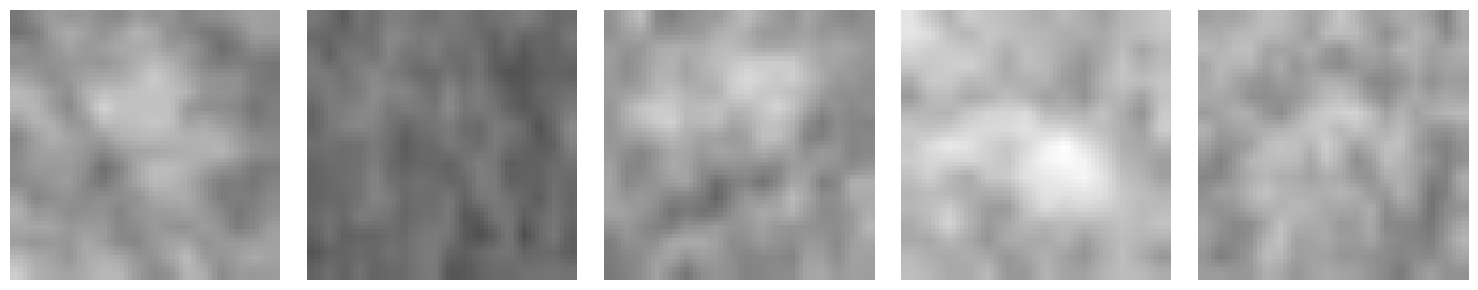

In [ ]:
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, df, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = []
        self.item_dict = {}
        self.ratio = []
        self.item_paths = [os.path.join(self.folder_path, i).replace("Photo", "AF").replace("_2_0M", "_4_1M") for i in df["File Prefix1"]] #
        self.ratio = df["Ratio"].values

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        target = torch.tensor([self.ratio[idx]], dtype=torch.float32)
        return tensor_image, target

# Augmentation param
PX = 64 #画像のサイズ
TRAIN_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14,  0.114, 0.072]
TRAIN_CROP_SCALE =(0.75,1.0)
TRAIN_BRIGHTNESS_PARAM = 0.05
TRAIN_CONTRAST_PARAM = 0.05
TRAIN_SATURATION_PARAM = 0.05
TRAIN_RANDOM_ROTATION = 0
TRAIN_HUE_PARAM = 0.005
VAL_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14,  0.114, 0.072]

# Training param
PATIENCE = 30
EPOCH = 300
BATCH_SIZE = 64


# Update the transform compositions using v2
train_data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
    #transforms.ColorJitter(brightness=TRAIN_BRIGHTNESS_PARAM,contrast=TRAIN_CONTRAST_PARAM,saturation=TRAIN_SATURATION_PARAM,hue=TRAIN_HUE_PARAM),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    #transforms.Normalize(mean=TRAIN_NORMALIZE_PARAM[0], std=TRAIN_NORMALIZE_PARAM[1]),
])

val_data_transforms = transforms.Compose([
    transforms.Resize((PX, PX), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    #transforms.Normalize(mean=TRAIN_NORMALIZE_PARAM[0], std=TRAIN_NORMALIZE_PARAM[1]),
])




train_df = filtered_df.sample(frac=0.8, random_state=42)
val_df = filtered_df.drop(train_df.index)

train_dataset = SimpleImageDataset(cropped_img_dir, train_df, train_data_transforms)
val_dataset = SimpleImageDataset(cropped_img_dir, val_df, val_data_transforms)
test_dataset = SimpleImageDataset(cropped_img_dir, val_df, train_data_transforms)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(val_dataset, batch_size = 1, shuffle = False)


print("TRAIN_dataset_size：" + str(len(train_dataset)))
print("VAL_dataset_size：" + str(len(val_dataset)))
print("TEST_dataset_size：" + str(len(test_dataset)))


#水増し後の画像を表示
def show_img(dataset):
    plt.figure(figsize=(15, 3))
    for i in range(5):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)
        plt.subplot(1, 5, i+1)

        # 軸と補助線を完全に非表示にする
        plt.axis('off')

        plt.imshow(image)
    plt.tight_layout()  # サブプロット間の間隔を自動調整


#画像の可視化
show_img(train_dataset)



In [ ]:
from torchvision.models import ResNet50_Weights

# class LaserSpotResNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # ResNet18をベースに転移学習 - pretrainedの代わりにweightsを使用
#         self.resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
#         # 入力層を64x64x3に対応
#         self.resnet.conv1 = nn.Conv2d(3, 64, 7, stride=1, padding=3)
#         self.resnet.maxpool = nn.MaxPool2d(2, stride=2)
#         # 回帰のための出力層
#         self.resnet.fc = nn.Sequential(
#             nn.Linear(512, 128),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(128, 1)
#         )

#     def forward(self, x):
#         return self.resnet(x)

# class LaserSpotResNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # ResNet18をベースに転移学習
#         self.resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
#         # 入力層を64x64x3に対応
#         self.resnet.conv1 = nn.Conv2d(3, 64, 7, stride=1, padding=3)
#         self.resnet.maxpool = nn.MaxPool2d(2, stride=2)

#         # 回帰のための出力層を改良
#         self.resnet.fc = nn.Sequential(
#             nn.Linear(512, 256),
#             nn.BatchNorm1d(256),  # BatchNormを追加
#             nn.ReLU(),
#             nn.Dropout(0.3),      # 最初のDropoutは少し控えめに

#             nn.Linear(256, 128),
#             nn.BatchNorm1d(128),  # BatchNormを追加
#             nn.ReLU(),
#             nn.Dropout(0.5),      # 後ろの層ほどDropoutを強めに

#             nn.Linear(128, 1)
#         )

#     def forward(self, x):
#         return self.resnet(x)

class LaserSpotResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)

        self.gap = nn.AdaptiveAvgPool2d(1)

        # Dropoutを減らし、より単純な構造に
        self.regressor = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),  # 0.2→0.1に減少
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.gap(x)
        x = x.view(x.size(0), -1)

        return self.regressor(x)

# モデル定義
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft = LaserSpotResNet().to(device)

# 学習設定 - 重複している最適化設定を統合
criterion = nn.MSELoss()


# ステップ数の計算
steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * EPOCH

optimizer = torch.optim.AdamW(
    model_ft.parameters(),
    lr=5e-5,  # 現状維持
    weight_decay=0.003,  # さらに少し軽減
    betas=(0.9, 0.999)
)

# エポック数を増やし、より緩やかな学習を実現
scheduler = lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=5e-4,  # 現状維持
    total_steps=total_steps,
    pct_start=0.4,  # warm-upをより長く
    anneal_strategy='cos',
    div_factor=10.0,
    final_div_factor=1e3
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 224MB/s]


#**Modules**

In [ ]:
####################################
####################################
#Test with early-stopping
####################################
####################################

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss



def train_model(model, loss_func, batch_size, optimizer, patience, n_epochs, device):
    # steps_per_epochの計算
    steps_per_epoch = len(train_loader)
    total_steps = steps_per_epoch * n_epochs

    # OneCycleLRの設定
    scheduler = lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        total_steps=total_steps,
        pct_start=0.3,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=1e4
    )

    # AMP用のscalerを初期化
    scaler = torch.cuda.amp.GradScaler()

    # 損失の記録用リスト
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []

    # early stoppingの初期化
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(1, n_epochs + 1):
        ###################
        # train the model #
        ###################
        model.train()
        running_corrects, train_acc = 0, 0

        for batch, (image_tensor, target) in enumerate(train_loader, 1):
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)

            # 勾配をゼロに初期化
            optimizer.zero_grad()

            # AMPを使用した順伝播
            with torch.cuda.amp.autocast():
                output = model(image_tensor)
                loss = loss_func(output, target)

            # AMPを使用した逆伝播
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # OneCycleLRはバッチごとに更新
            scheduler.step()

            # 現在の学習率を記録
            current_lr = optimizer.param_groups[0]['lr']

            train_losses.append(loss.item())

        ######################
        # validate the model #
        ######################
        model.eval()
        running_corrects, val_acc = 0, 0

        with torch.no_grad():
            for image_tensor, target in val_loader:
                target = target.view(len(target), 1)

                image_tensor = image_tensor.to(device)
                target = target.to(device)

                # 評価時もAMPを使用
                with torch.cuda.amp.autocast():
                    output = model(image_tensor)
                    loss = loss_func(output, target)

                valid_losses.append(loss.item())

        # 平均損失の計算
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(n_epochs))
        print_msg = (f'Epoch: [{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +'\n'
                    f'train_loss: {train_loss:.5f} ' +'\n'
                    f'valid_loss: {valid_loss:.5f} ' +'\n'
                    f'learning_rate: {current_lr:.2e}')
        print(print_msg)

        # リストのクリア
        train_losses = []
        valid_losses = []

        # early stopping
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # 最良のモデルを読み込み
    model.load_state_dict(torch.load('checkpoint.pt'))

    return model, avg_train_losses, avg_valid_losses



#**Train model & save network**

<ipython-input-10-3d6b27a29e72>:75: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-10-3d6b27a29e72>:103: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
<ipython-input-10-3d6b27a29e72>:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.

Epoch: [  1/300] 
train_loss: 0.82655 
valid_loss: 0.60409 
learning_rate: 4.03e-05
Validation loss decreased (inf --> 0.604094).  Saving model ...
Epoch: [  2/300] 
train_loss: 0.66025 
valid_loss: 0.98166 
learning_rate: 4.12e-05
EarlyStopping counter: 1 out of 30
Epoch: [  3/300] 
train_loss: 0.48883 
valid_loss: 0.82949 
learning_rate: 4.26e-05
EarlyStopping counter: 2 out of 30
Epoch: [  4/300] 
train_loss: 0.34154 
valid_loss: 0.33496 
learning_rate: 4.47e-05
Validation loss decreased (0.604094 --> 0.334955).  Saving model ...
Epoch: [  5/300] 
train_loss: 0.23857 
valid_loss: 0.25742 
learning_rate: 4.73e-05
Validation loss decreased (0.334955 --> 0.257421).  Saving model ...
Epoch: [  6/300] 
train_loss: 0.16644 
valid_loss: 0.27664 
learning_rate: 5.05e-05
EarlyStopping counter: 1 out of 30
Epoch: [  7/300] 
train_loss: 0.13226 
valid_loss: 0.16017 
learning_rate: 5.43e-05
Validation loss decreased (0.257421 --> 0.160167).  Saving model ...
Epoch: [  8/300] 
train_loss: 0.1187

<ipython-input-10-3d6b27a29e72>:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


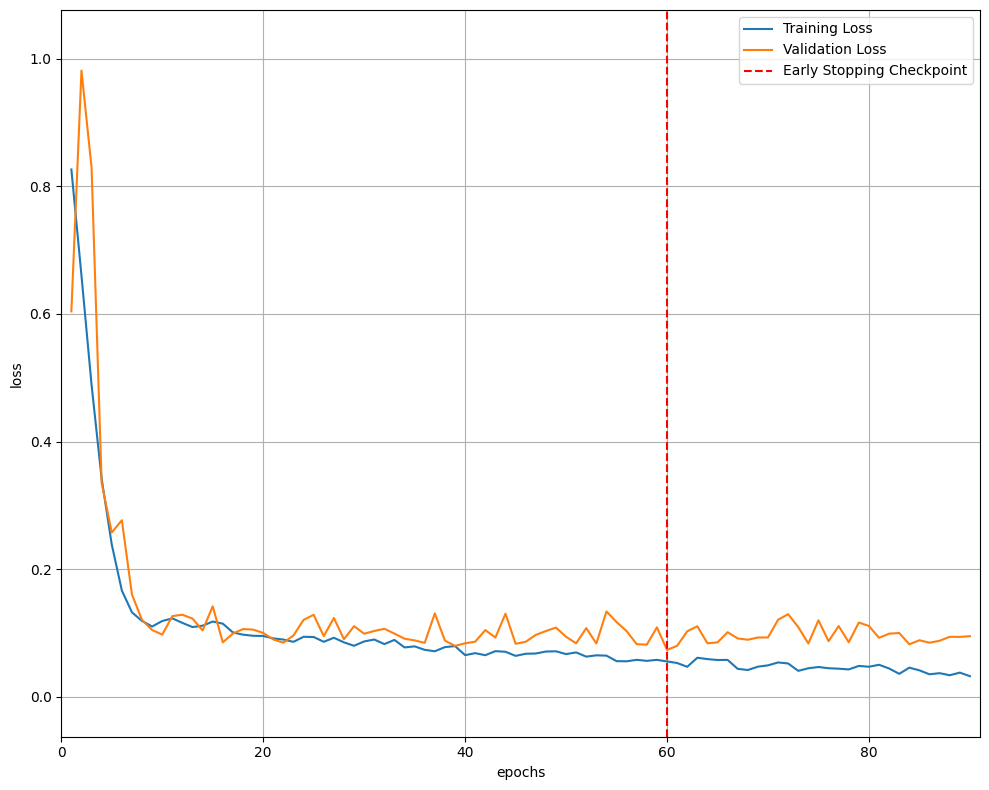

In [ ]:
model, train_loss, valid_loss = train_model(model_ft, criterion, BATCH_SIZE, optimizer, PATIENCE, EPOCH, device)

#ネットワークの保存
PATH = 'test.pth'
torch.save(model_ft.state_dict(), PATH)

# Drawing learning curves
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

# データの最小値と最大値を取得
min_loss = min(min(train_loss), min(valid_loss))
max_loss = max(max(train_loss), max(valid_loss))

# マージンを追加して少し余裕を持たせる（例：10%のマージン）
margin = (max_loss - min_loss) * 0.1
plt.ylim(min_loss - margin, max_loss + margin)

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [ ]:
PATIENCE = 30  # 例えば、30エポック改善しなかったら学習を停止


Epoch: [  1/300] 
train_loss: 0.59841 
valid_loss: 0.83168 
learning_rate: 1.00e-04
Validation loss decreased (0.831684 --> 0.831684).  Saving model ...
Epoch: [  2/300] 
train_loss: 0.53722 
valid_loss: 0.88073 
learning_rate: 1.01e-04
Epoch: [  3/300] 
train_loss: 0.49018 
valid_loss: 0.91133 
learning_rate: 1.02e-04
Epoch: [  4/300] 
train_loss: 0.43571 
valid_loss: 0.98551 
learning_rate: 1.04e-04
Epoch: [  5/300] 
train_loss: 0.36218 
valid_loss: 0.65012 
learning_rate: 1.07e-04
Validation loss decreased (0.650122 --> 0.650122).  Saving model ...
Epoch: [  6/300] 
train_loss: 0.29820 
valid_loss: 0.97319 
learning_rate: 1.10e-04
Epoch: [  7/300] 
train_loss: 0.24747 
valid_loss: 0.81295 
learning_rate: 1.13e-04
Epoch: [  8/300] 
train_loss: 0.18403 
valid_loss: 0.32102 
learning_rate: 1.18e-04
Validation loss decreased (0.321016 --> 0.321016).  Saving model ...
Epoch: [  9/300] 
train_loss: 0.14346 
valid_loss: 0.16625 
learning_rate: 1.22e-04
Validation loss decreased (0.166247 -

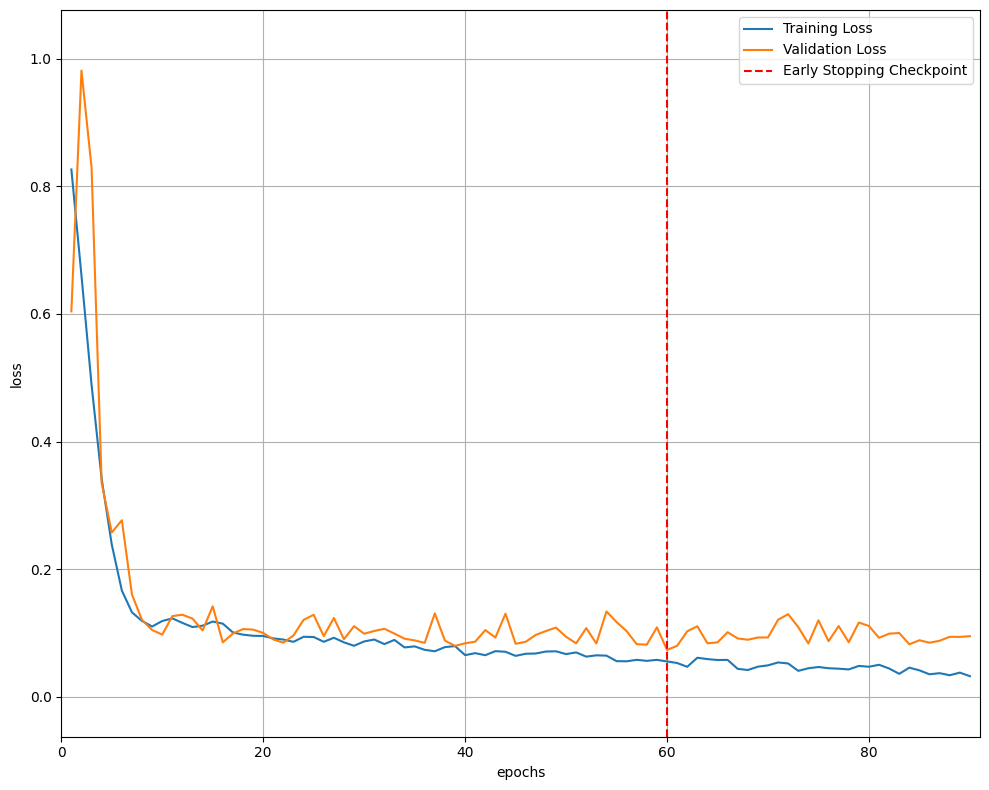

In [ ]:
#32pxバージョン

class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, df, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = []
        self.item_dict = {}
        self.ratio = []

        self.item_paths = [os.path.join(self.folder_path, i) for i in df["File Prefix1"]]
        self.ratio = df["Ratio"].values

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        target = torch.tensor([self.ratio[idx]], dtype=torch.float32)
        return tensor_image, target

# Augmentation param
PX = 32  # 入力サイズを32pxに変更
TRAIN_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14, 0.114, 0.072]
TRAIN_CROP_SCALE = (0.9, 1.0)  # より控えめなcrop
TRAIN_BRIGHTNESS_PARAM = 0.02   # より控えめな色変更
TRAIN_CONTRAST_PARAM = 0.02
TRAIN_SATURATION_PARAM = 0.02
TRAIN_RANDOM_ROTATION = 5      # 少しだけ回転を許可
TRAIN_HUE_PARAM = 0.002
VAL_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14, 0.114, 0.072]

# Training param
PATIENCE = 30
EPOCH = 300
BATCH_SIZE = 256  # バッチサイズを増加

# データ拡張の定義
train_data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE,
                               interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
    transforms.ColorJitter(brightness=TRAIN_BRIGHTNESS_PARAM,
                         contrast=TRAIN_CONTRAST_PARAM,
                         saturation=TRAIN_SATURATION_PARAM,
                         hue=TRAIN_HUE_PARAM),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

val_data_transforms = transforms.Compose([
    transforms.Resize((PX, PX), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

# Early Stopping実装
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            return False

        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        return self.early_stop

# モデル定義
class LaserSpotResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        # 32x32の入力サイズに対応
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.resnet.maxpool = nn.Identity()  # maxpoolを無効化（小さな入力サイズのため）

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.regressor = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.gap(x)
        x = x.view(x.size(0), -1)

        return self.regressor(x)

# データセットの分割
train_df = filtered_df.sample(frac=0.8, random_state=42)
val_df = filtered_df.drop(train_df.index)

train_dataset = SimpleImageDataset(cropped_img_dir, train_df, train_data_transforms)
val_dataset = SimpleImageDataset(cropped_img_dir, val_df, val_data_transforms)
test_dataset = SimpleImageDataset(cropped_img_dir, val_df, val_data_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# デバイスの設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft = LaserSpotResNet().to(device)

# 損失関数と最適化の設定
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(
    model_ft.parameters(),
    lr=1e-4,
    weight_decay=0.001,
    betas=(0.9, 0.999)
)

# ステップ数の計算とスケジューラーの設定
steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * EPOCH

scheduler = lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    total_steps=total_steps,
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=10.0,
    final_div_factor=1e3
)

early_stopping = EarlyStopping(patience=PATIENCE, min_delta=1e-4)

# 学習ループ
def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCH):
    best_loss = float('inf')

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss = val_loss / len(val_loader.dataset)

        print(f'Epoch: [{epoch:3d}/{num_epochs}] \n'
              f'train_loss: {epoch_loss:.5f} \n'
              f'valid_loss: {val_loss:.5f} \n'
              f'learning_rate: {scheduler.get_last_lr()[0]:.2e}')

        # Early stopping check
        if early_stopping(val_loss, model):
            print("Early stopping triggered")
            model.load_state_dict(early_stopping.best_model)
            break

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'checkpoint.pt')
            print(f'Validation loss decreased ({best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')

# 学習の実行
train_model(model_ft, criterion, optimizer, scheduler)

# モデルの読み込み
model_ft.load_state_dict(torch.load('checkpoint.pt', weights_only=True))

#ネットワークの保存
PATH = 'test.pth'
torch.save(model_ft.state_dict(), PATH)

# Drawing learning curves
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

# データの最小値と最大値を取得
min_loss = min(min(train_loss), min(valid_loss))
max_loss = max(max(train_loss), max(valid_loss))

# マージンを追加して少し余裕を持たせる（例：10%のマージン）
margin = (max_loss - min_loss) * 0.1
plt.ylim(min_loss - margin, max_loss + margin)

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Epoch [1/300] - train_loss: 0.67070 - valid_loss: 0.72483
Epoch [2/300] - train_loss: 0.63674 - valid_loss: 0.65001
Epoch [3/300] - train_loss: 0.60384 - valid_loss: 0.53044
Epoch [4/300] - train_loss: 0.57497 - valid_loss: 0.43527
Epoch [5/300] - train_loss: 0.56688 - valid_loss: 0.39838
Epoch [6/300] - train_loss: 0.54506 - valid_loss: 0.37036
Epoch [7/300] - train_loss: 0.50365 - valid_loss: 0.41824
Epoch [8/300] - train_loss: 0.46829 - valid_loss: 0.43668
Epoch [9/300] - train_loss: 0.44483 - valid_loss: 0.40819
Epoch [10/300] - train_loss: 0.39256 - valid_loss: 0.36798
Epoch [11/300] - train_loss: 0.34914 - valid_loss: 0.34285
Epoch [12/300] - train_loss: 0.30153 - valid_loss: 0.33672
Epoch [13/300] - train_loss: 0.24967 - valid_loss: 0.32942
Epoch [14/300] - train_loss: 0.21622 - valid_loss: 0.27918
Epoch [15/300] - train_loss: 0.17922 - valid_loss: 0.24977
Epoch [16/300] - train_loss: 0.14100 - valid_loss: 0.21318
Epoch [17/300] - train_loss: 0.11317 - valid_loss: 0.17935
Epoch 

<ipython-input-14-94f7b4b3e2bc>:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load("test.pth"))


               result
AveError     0.000043
StdError     0.256921
AveAbsError  0.196422
StdAbsError  0.165610


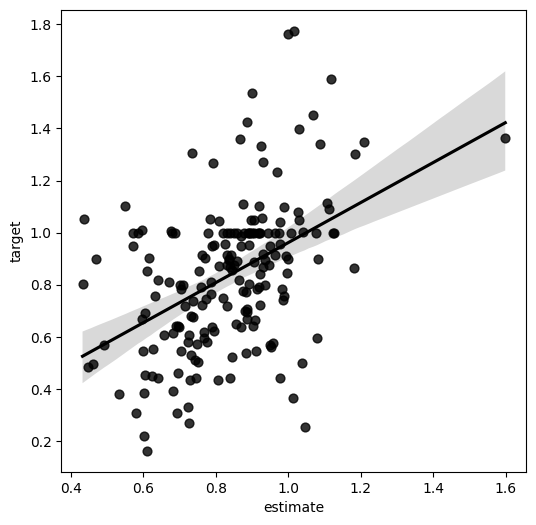

In [ ]:

import os
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import ResNet50_Weights
from torch.optim import lr_scheduler
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ✅ Dataset Class
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, df, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = [os.path.join(self.folder_path, i) for i in df["File Prefix1"]]
        self.ratio = df["Ratio"].values

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        target = torch.tensor([self.ratio[idx]], dtype=torch.float32)
        return tensor_image, target

# ✅ Augmentation parameters
PX = 32
TRAIN_CROP_SCALE = (0.9, 1.0)
TRAIN_BRIGHTNESS_PARAM = 0.02
TRAIN_CONTRAST_PARAM = 0.02
TRAIN_SATURATION_PARAM = 0.02
TRAIN_RANDOM_ROTATION = 5
TRAIN_HUE_PARAM = 0.002
BATCH_SIZE = 256
PATIENCE = 30
EPOCH = 300

# ✅ Data transformations (修正後)
train_data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
    transforms.ColorJitter(brightness=TRAIN_BRIGHTNESS_PARAM, contrast=TRAIN_CONTRAST_PARAM,
                           saturation=TRAIN_SATURATION_PARAM, hue=TRAIN_HUE_PARAM),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

val_data_transforms = transforms.Compose([
    transforms.Resize((PX, PX), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

# ✅ Early Stopping class
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

# ✅ Model definition
class LaserSpotResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.resnet.maxpool = nn.Identity()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.regressor = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        return self.regressor(x)

# ✅ Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCH):
    early_stopping = EarlyStopping(patience=PATIENCE, min_delta=1e-4)
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)

        print(f"Epoch [{epoch}/{num_epochs}] - train_loss: {epoch_loss:.5f} - valid_loss: {val_loss:.5f}")
        if early_stopping(val_loss, model):
            print("Early stopping triggered")
            model.load_state_dict(early_stopping.best_model)
            break

# ✅ Train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft = LaserSpotResNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model_ft.parameters(), lr=1e-4, weight_decay=0.001)
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, total_steps=EPOCH * len(train_loader))

train_model(model_ft, criterion, optimizer, scheduler)

# ✅ Save trained model
torch.save(model_ft.state_dict(), 'test.pth')

# ✅ Evaluation
model_ft.load_state_dict(torch.load("test.pth"))
model_ft.to(device)
model_ft.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_ft(inputs)
        y_true.append(labels.cpu().numpy().flatten())
        y_pred.append(outputs.cpu().numpy().flatten())

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)

# ✅ Error metrics
errors = y_pred - y_true
AveError = np.mean(errors)
StdError = np.std(errors)
AveAbsError = np.mean(np.abs(errors))
StdAbsError = np.std(np.abs(errors))

results_df = pd.DataFrame({"result": [AveError, StdError, AveAbsError, StdAbsError]},
                          index=["AveError", "StdError", "AveAbsError", "StdAbsError"])
print(results_df)

# ✅ Scatter plot
plt.figure(figsize=(6, 6))
sns.regplot(x=y_pred, y=y_true, scatter_kws={"s": 40, "color": "black"}, line_kws={"color": "black"}, ci=95)
plt.xlabel("estimate")
plt.ylabel("target")
plt.show()




In [ ]:
import os
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import ResNet50_Weights
from torch.optim import lr_scheduler
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Dataset Class
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, df, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = [os.path.join(self.folder_path, i) for i in df["File Prefix1"]]
        self.ratio = df["Ratio"].values

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        target = torch.tensor([self.ratio[idx]], dtype=torch.float32)
        return tensor_image, target

# Augmentation parameters
PX = 32
TRAIN_CROP_SCALE = (0.9, 1.0)
TRAIN_BRIGHTNESS_PARAM = 0.02
TRAIN_CONTRAST_PARAM = 0.02
TRAIN_SATURATION_PARAM = 0.02
TRAIN_RANDOM_ROTATION = 5
TRAIN_HUE_PARAM = 0.002
BATCH_SIZE = 256
PATIENCE = 30
EPOCH = 300

# Data transformations
train_data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
    transforms.ColorJitter(brightness=TRAIN_BRIGHTNESS_PARAM, contrast=TRAIN_CONTRAST_PARAM,
                           saturation=TRAIN_SATURATION_PARAM, hue=TRAIN_HUE_PARAM),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

val_data_transforms = transforms.Compose([
    transforms.Resize((PX, PX), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

# Model definition
class LaserSpotResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.resnet.maxpool = nn.Identity()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.regressor = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        return self.regressor(x)

# Define dataset paths
cropped_img_dirs = [
    "/content/drive/MyDrive/Patient_1_Cropped",
    "/content/drive/MyDrive/Patient13R_Cropped",
    "/content/drive/MyDrive/Patient21R_Cropped"
]

filtered_df = pd.DataFrame()  # Replace with actual DataFrame loading logic
train_df, val_df = train_test_split(filtered_df, test_size=0.2, random_state=42)

train_dataset = SimpleImageDataset(cropped_img_dirs[0], train_df, train_data_transforms)
val_dataset = SimpleImageDataset(cropped_img_dirs[0], val_df, val_data_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft = LaserSpotResNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model_ft.parameters(), lr=1e-4, weight_decay=0.001)
steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * EPOCH
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, total_steps=total_steps, pct_start=0.3, anneal_strategy='cos', div_factor=10.0, final_div_factor=1e3)

# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCH):
    early_stopping = EarlyStopping(patience=PATIENCE, min_delta=1e-4)
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        if early_stopping(val_loss, model):
            model.load_state_dict(early_stopping.best_model)
            break

train_model(model_ft, criterion, optimizer, scheduler)
torch.save(model_ft.state_dict(), 'test.pth')



ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

#**Evaluation using testset**

In [ ]:
PATH = 'test.pth'
model_ft.load_state_dict(torch.load(PATH))

<ipython-input-15-0d5ce215a03f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load(PATH))


<All keys matched successfully>

#**Result analysis**

In [ ]:
import statistics

def my_round(x, d=0): #四捨五入
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p


model_ft.eval() # prep model for evaluation

outputs,targets,errors =[], [], []
for image_tensor, target in test_loader:
      target = target.view(len(target), 1)
      image_tensor = image_tensor.to(device)
      target = target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model_ft(image_tensor)

      outputs.append((output[0]*100).item())
      targets.append((target[0]*100).item())
      #print('estimate R:'+str(my_round(output[0,0].item()))+'mm, L:'+str(my_round(output[0,1].item()))+'mm / target R:'+str(target[0,0].item())+'mm, L:'+str(target[0,1].item())+'mm')

      errors.append((output[0]*100).item()-(target[0]*100).item())

AbsError = [abs(i) for i in errors]

print('AveError: '+str(statistics.mean(errors)))
print('StdError: '+str(statistics.stdev(errors)))
print('AveAbsError: '+str(statistics.mean(AbsError)))
print('StdAbsError: '+str(statistics.stdev(AbsError)))


#平均からの差分を補正
corrected_output = (np.array(outputs)-np.array(statistics.mean(errors))).tolist()
corrected_error = (np.array(corrected_output)-np.array(targets)).tolist()
corrected_AbsError = [abs(i) for i in corrected_error]

round_output = [my_round(i) for i in outputs]
round_corrected_AbsError = [my_round(i) for i in corrected_AbsError]

print('Corrected_AveAbsError: '+str(statistics.mean(corrected_AbsError)))
print('Corrected_StdAbsError: '+str(statistics.stdev(corrected_AbsError)))


#csvを作成して保存
columns = ["result"]
index = ["AveError", "StdError", "AveAbsError", "StdAbsError", "Corrected_AveAbsError", "Corrected_StdAbsError"]
df = pd.DataFrame(index=index, columns=columns)
df.iloc[0:6, 0] =[statistics.mean(errors),statistics.stdev(errors),statistics.mean(AbsError),statistics.stdev(AbsError), statistics.mean(corrected_AbsError),statistics.stdev(corrected_AbsError)]
print(df)

PATH = 'test.csv'
df.to_csv(index=True)

AveError: 0.004253703642656459
StdError: 25.761071562289132
AveAbsError: 19.642216534538065
StdAbsError: 16.605477188712086
Corrected_AveAbsError: 19.64223928161637
Corrected_StdAbsError: 16.605449589295503
                          result
AveError                0.004254
StdError               25.761072
AveAbsError            19.642217
StdAbsError            16.605477
Corrected_AveAbsError  19.642239
Corrected_StdAbsError   16.60545


',result\nAveError,0.004253703642656459\nStdError,25.761071562289132\nAveAbsError,19.642216534538065\nStdAbsError,16.605477188712086\nCorrected_AveAbsError,19.64223928161637\nCorrected_StdAbsError,16.605449589295503\n'

<ipython-input-17-d49ee54860ec>:30: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


<Figure size 640x480 with 0 Axes>

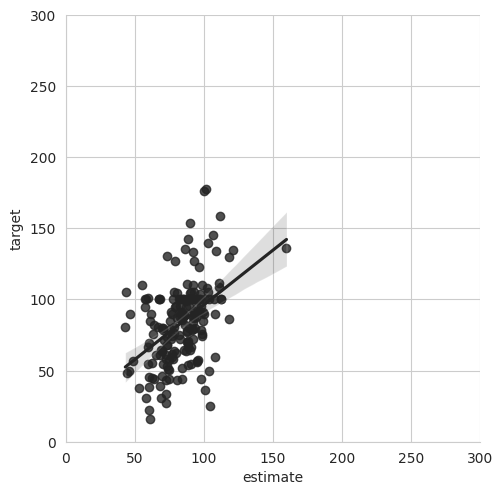

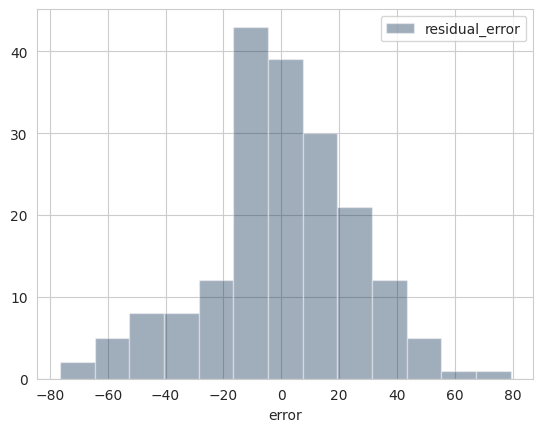

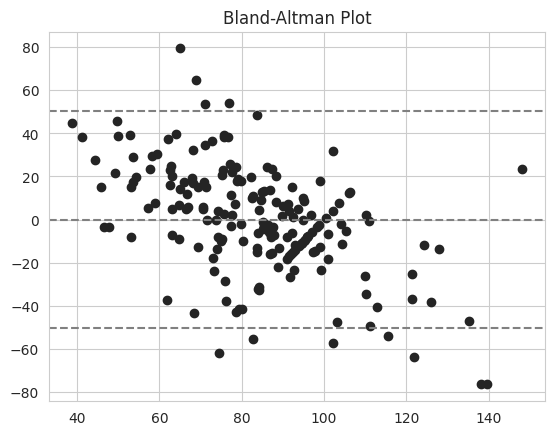

In [ ]:
import seaborn as sns

#Draw Graphs（散布図)
df = pd.DataFrame({'estimate':outputs, 'target':targets})


#Scatterplot
plt.figure()
sns.set_style('whitegrid')
sns.set_palette('gray')
figure = sns.lmplot(x='estimate', y='target', data=df)
plt.xlim(0,300)
plt.ylim(0,300)




PATH = 'test.png'
figure.savefig(PATH)



#Draw histogram
plt.figure()

df['error']=""
for i in range(len(df)):
    df.iloc[i,2] = df.iloc[i,0]-df.iloc[i,1]

sns.distplot(
    df['error'], bins=13, color='#123456', label='residual_error',
    kde=False,
    rug=False
)
plt.legend() # 凡例を表示
plt.show()   # ヒストグラムを表示



#Bland-Altman-Plot
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')

bland_altman_plot(outputs, targets)
plt.title('Bland-Altman Plot')
plt.show()

#**結果をCSVファイルに記載**

In [ ]:
#result.csv作成（ファイルがなければ）
if os.path.exists(FILENAME_RESULTCSV) == False:
    df_result = df_labelcsv.copy()
else:
    print(FILENAME_RESULTCSV + " already exists!")

df_result = pd.read_csv(FILENAME_RESULTCSV, index_col=0)
print(df_result)


"""
################
#df_resultを初期化
################

df_result = df_labelcsv.copy()
df_result["set"] = "0"  #工程の列を追加

#valフォルダ内のファイル名を取得
train_data_path = glob.glob(DATASET_NAME + "/" + TRAIN_FOLDER_NAME+"/*")
val_data_path = glob.glob(DATASET_NAME + "/" + VAL_FOLDER_NAME+"/*")
test_data_path = glob.glob(DATASET_NAME + "/" + TEST_FOLDER_NAME+"/*")

for i in train_data_path:
    df_result.loc[df_result.iloc[:,0] == os.path.basename(i), "set"] = "train"
for i in val_data_path:
    df_result.loc[df_result.iloc[:,0] == os.path.basename(i), "set"] = "val"
for i in test_data_path:
    df_result.loc[df_result.iloc[:,0] == os.path.basename(i), "set"] = "test"

print(df_result)
"""

NameError: name 'FILENAME_RESULTCSV' is not defined

In [ ]:
import pandas as pd
import os

# 保存するデータフレームを作成
df_results = pd.DataFrame({
    "Predicted": outputs,
    "Actual": targets,
    "Error": errors,
    "Absolute Error": AbsError
})

# 出力先フォルダを作成（なければ）
output_folder = "results"
os.makedirs(output_folder, exist_ok=True)

# ファイルパスを設定して保存
csv_filename = os.path.join(output_folder, "test_secondresults.csv")
df_results.to_csv(csv_filename, index=False)

print(f"Results saved to {csv_filename}")


Results saved to results/test_results.csv


In [ ]:
#Calculating result

#対象のパスからラベルを抜き出して表示
def getlabel(result_csv, image_name):
      image_name = image_name
      label = df_result[df_result.iloc[:,0] == image_name].iloc[0,1] #df_resultよりimage_nameが含まれる行を抜き出して年齢を取得
      return(image_name, label)


#評価のための画像下処理
def image_transform(image_path):
    image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor()])
    image_tensor = transform(image)


    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる

    return(image_tensor)


def my_round(x, d=0): #四捨五入
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p


#モデルにした処理した画像を投入して予測結果を出力
def image_eval(image_tensor, model_ft):
    output = model_ft(image_tensor).item()*100
    return output

#result.csvに結果を記入
def write_result(df, image_name, pred, row):
    df.loc[df_result.iloc[:,0] == image_name, row] = pred  #df_resultよりimage_nameが含まれる行を抜き出して年齢を取得




#ここからがメイン
model_ft.eval() # prep model for evaluation

#valフォルダ内のファイル名を取得
train_data_path = glob.glob(DATASET_NAME + "/" + TRAIN_FOLDER_NAME+"/*")
val_data_path = glob.glob(DATASET_NAME + "/" + VAL_FOLDER_NAME+"/*")
test_data_path = glob.glob(DATASET_NAME + "/" + TEST_FOLDER_NAME+"/*")

data_path = [train_data_path, val_data_path, test_data_path]
k=0
for j in data_path:
    for i in j:
          image_name, label = getlabel(df_result, os.path.basename(i))  #画像の名前とラベルを取得
          image_tensor = image_transform(i)  #予測のための画像下処理
          pred = image_eval(image_tensor, model_ft)  #予測結果を出力
          write_result(df_result, image_name, pred, MODEL_NAME)
          print(str(k)+"/"+str(len(df_result)) + " images processed!")
          k+=1
print(df_result)

NameError: name 'DATASET_NAME' is not defined

In [ ]:
#Resultファイルを書き出し
df_result.to_csv(FILENAME_RESULTCSV)

In [ ]:
import os

print("Current working directory:", os.getcwd())  # 現在の作業ディレクトリを表示


Current working directory: /content


In [ ]:
import os
import pandas as pd
import glob
from sklearn.model_selection import train_test_split

def load_and_filter_data(csv_paths, cropped_img_dirs, first_characters_list):
    """
    指定されたCSVファイルを読み込み、first_charactersに一致するデータを取得。
    """
    all_data = []

    for csv_path, img_dir, first_characters in zip(csv_paths, cropped_img_dirs, first_characters_list):
        # CSVを読み込む
        df = pd.read_csv(csv_path)

        # 指定の文字列でフィルタリング
        filtered_df = df[df["File Prefix1"].str.startswith(first_characters)]

        # 画像のパスを取得
        filtered_df["Image Path"] = filtered_df["File Prefix1"].apply(lambda x: glob.glob(os.path.join(img_dir, x + "*.png")))

        all_data.append(filtered_df)

    # すべてのデータを結合
    final_df = pd.concat(all_data, ignore_index=True)
    return final_df

# 指定するCSVファイルと対応する画像フォルダ、フィルタリング条件
csv_paths = [
    "/content/drive/MyDrive/Pixel_Comparison2YearsPatient1_Tracks_1_to_1004.csv",
    "/content/drive/MyDrive/Pixel_Comparison2Y3MPatient13R_Tracks_1_to_1010.csv",
    "/content/drive/MyDrive/Pixel_Comparison_Patient21R_0MPhoto_1Y3MPhoto.csv"
]

cropped_img_dirs = [
    "/content/drive/MyDrive/Patient_1_Cropped",
    "/content/drive/MyDrive/Patient13R_Cropped",
    "/content/drive/MyDrive/Patient21R_Cropped"
]

first_characters_list = ["pt1_2_0M", "Pt13R_2_0M", "Pt21R_2_0M"]

# データを読み込む
final_dataset = load_and_filter_data(csv_paths, cropped_img_dirs, first_characters_list)

# 学習用と検証用に分割
df_train, df_val = train_test_split(final_dataset, test_size=0.2, random_state=42)

# 結果を表示
print("Train Data: ", df_train.shape)
print("Validation Data: ", df_val.shape)
print(df_train.head())


KeyboardInterrupt: 

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd

def load_and_filter_data(csv_paths, cropped_img_dirs, first_characters_list):
    all_data = []
    for csv_path, img_dir, first_characters in zip(csv_paths, cropped_img_dirs, first_characters_list):
        df = pd.read_csv(csv_path)
        filtered_df = df[df["File Prefix1"].str.startswith(first_characters)]
        filtered_df["Image Path"] = filtered_df["File Prefix1"].apply(lambda x: glob.glob(os.path.join(img_dir, x + "*.png")))
        all_data.append(filtered_df)
    final_df = pd.concat(all_data, ignore_index=True)
    return final_df

replace_dict = {
    "pt1_2_0M_Photo": "pt1_5_1.5M_AF",
    "Pt13R_2_0M_Photo": "Pt13R_4_1MAF",
    "Pt21R_2_0M_Photo": "Pt21R_3_1M_AF"
}

class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, df, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.ratio = df["Ratio"].values
        self.item_paths = [os.path.join(self.folder_path, replace_dict.get(i, i) + ".png") for i in df["File Prefix1"]]

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        target = torch.tensor([self.ratio[idx]], dtype=torch.float32)
        return tensor_image, target

PX = 64
TRAIN_CROP_SCALE = (0.75, 1.0)
TRAIN_RANDOM_ROTATION = 0

train_data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
    transforms.ToTensor(),
])

val_data_transforms = transforms.Compose([
    transforms.Resize((PX, PX), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

csv_paths = [
    "/content/drive/MyDrive/Pixel_Comparison2YearsPatient1_Tracks_1_to_1004.csv",
    "/content/drive/MyDrive/Pixel_Comparison2Y3MPatient13R_Tracks_1_to_1010.csv",
    "/content/drive/MyDrive/Pixel_Comparison_Patient21R_0MPhoto_1Y3MPhoto.csv"
]

cropped_img_dirs = [
    "/content/drive/MyDrive/Patient_1_Cropped",
    "/content/drive/MyDrive/Patient13R_Cropped",
    "/content/drive/MyDrive/Patient21R_Cropped"
]

first_characters_list = ["pt1_5_1.5M_AF", "Pt13R_4_1MAF", "Pt21R_3_1M_AF"]

final_dataset = load_and_filter_data(csv_paths, cropped_img_dirs, first_characters_list)
df_train, df_val = train_test_split(final_dataset, test_size=0.2, random_state=42)

train_datasets = []
val_datasets = []
for filtered_df, img_dir in zip([df_train, df_val], cropped_img_dirs):
    train_datasets.append(SimpleImageDataset(img_dir, df_train, train_data_transforms))
    val_datasets.append(SimpleImageDataset(img_dir, df_val, val_data_transforms))

train_dataset = ConcatDataset(train_datasets)
val_dataset = ConcatDataset(val_datasets)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

print("TRAIN_dataset_size：" + str(len(train_dataset)))
print("VAL_dataset_size：" + str(len(val_dataset)))
print("TEST_dataset_size：" + str(len(val_dataset)))

def show_img(dataset):
    plt.figure(figsize=(15, 3))
    for i in range(5):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)
        plt.subplot(1, 5, i+1)
        plt.axis('off')
        plt.imshow(image)
    plt.tight_layout()

show_img(train_dataset)



ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

TRAIN_dataset_size：1941
VAL_dataset_size：485
TEST_dataset_size：485


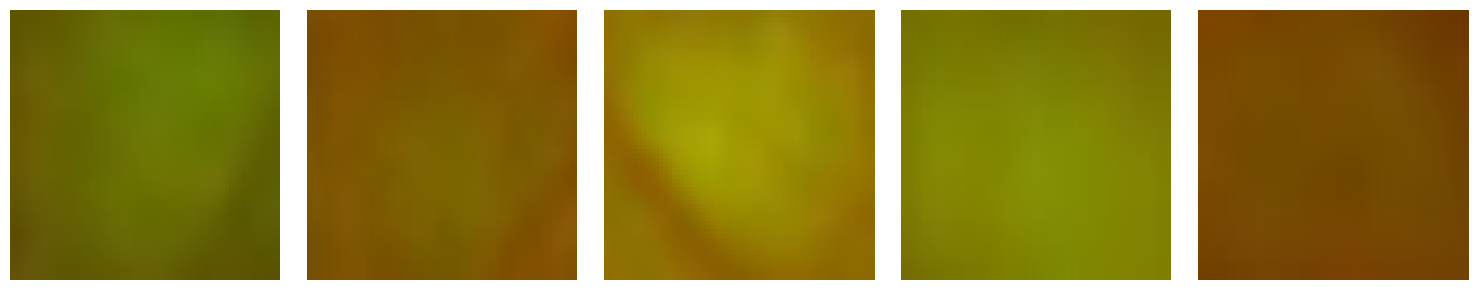

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd

# === CSVファイルと対応する画像フォルダの情報 ===
csv_paths = [
    "/content/drive/MyDrive/Pixel_Comparison2YearsPatient1_Tracks_1_to_1004.csv",
    "/content/drive/MyDrive/Pixel_Comparison2Y3MPatient13R_Tracks_1_to_1010.csv",
    "/content/drive/MyDrive/Pixel_Comparison_Patient21R_0MPhoto_1Y3MPhoto.csv"
]

cropped_img_dirs = [
    "/content/drive/MyDrive/Patient_1_Cropped",
    "/content/drive/MyDrive/Patient13R_Cropped",
    "/content/drive/MyDrive/Patient21R_Cropped"
]

first_characters_list = [
    "pt1_2_0M",
    "Pt13R_2_0M",
    "Pt21R_2_0M"
]

# === 前処理: CSVを読み込み、フィルタリング ===
filtered_data = []

for csv_path, img_dir, first_characters in zip(csv_paths, cropped_img_dirs, first_characters_list):
    df = pd.read_csv(csv_path)

    # 指定したプレフィックスでフィルタリング
    filtered_df = df[df["File Prefix1"].str.startswith(first_characters)]

    # リストに追加（データフレームと画像フォルダのペア）
    filtered_data.append((filtered_df, img_dir))

# === 置換ルール ===
replace_dict = {
    "pt1_2_0M": "pt1_5_1.5M_AF",
    "Pt13R_2_0M": "Pt13R_4_1MAF",
    "Pt21R_2_0M": "Pt21R_3_1M_AF"
}

# === PyTorch Dataset の作成 ===
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, df, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.ratio = df["Ratio"].values

        # 画像パスの生成（置換ルールを適用）
        self.item_paths = [
            os.path.join(self.folder_path, replace_dict.get(i, i)) for i in df["File Prefix1"]
        ]

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        target = torch.tensor([self.ratio[idx]], dtype=torch.float32)
        return tensor_image, target

# === Augmentation パラメータ ===
PX = 64  # 画像サイズ
TRAIN_CROP_SCALE = (0.75, 1.0)
TRAIN_RANDOM_ROTATION = 0

# データ変換（修正）
train_data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
    transforms.ToTensor(),  # 修正済み
])

val_data_transforms = transforms.Compose([
    transforms.Resize((PX, PX), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),  # 修正済み
])

# === Dataset & DataLoaderの作成 ===
train_datasets = []
val_datasets = []

for filtered_df, img_dir in filtered_data:
    train_df = filtered_df.sample(frac=0.8, random_state=42)
    val_df = filtered_df.drop(train_df.index)

    train_datasets.append(SimpleImageDataset(img_dir, train_df, train_data_transforms))
    val_datasets.append(SimpleImageDataset(img_dir, val_df, val_data_transforms))

# 複数のDatasetを結合
train_dataset = torch.utils.data.ConcatDataset(train_datasets)
val_dataset = torch.utils.data.ConcatDataset(val_datasets)

# DataLoaderの作成
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# データサイズの確認
print("TRAIN_dataset_size：" + str(len(train_dataset)))
print("VAL_dataset_size：" + str(len(val_dataset)))
print("TEST_dataset_size：" + str(len(val_dataset)))

# === データ可視化関数 ===
def show_img(dataset):
    plt.figure(figsize=(15, 3))
    for i in range(5):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)
        plt.subplot(1, 5, i+1)
        plt.axis('off')
        plt.imshow(image)
    plt.tight_layout()

# 画像の可視化
show_img(train_dataset)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd

# === CSVファイルと対応する画像フォルダの情報 ===
csv_paths = [
    "/content/drive/MyDrive/Pixel_Comparison2YearsPatient1_Tracks_1_to_1004.csv",
    "/content/drive/MyDrive/Pixel_Comparison2Y3MPatient13R_Tracks_1_to_1010.csv",
    "/content/drive/MyDrive/Pixel_Comparison_Patient21R_0MPhoto_1Y3MPhoto.csv"
]

cropped_img_dirs = [
    "/content/drive/MyDrive/Patient_1_Cropped",
    "/content/drive/MyDrive/Patient13R_Cropped",
    "/content/drive/MyDrive/Patient21R_Cropped"
]

first_characters_list = [
    "pt1_2_0M",
    "Pt13R_2_0M",
    "Pt21R_2_0M"
]

# === 前処理: CSVを読み込み、フィルタリング ===
filtered_data = []

for csv_path, img_dir, first_characters in zip(csv_paths, cropped_img_dirs, first_characters_list):
    df = pd.read_csv(csv_path)

    # 指定したプレフィックスでフィルタリング
    filtered_df = df[df["File Prefix1"].str.startswith(first_characters)]

    # リストに追加（データフレームと画像フォルダのペア）
    filtered_data.append((filtered_df, img_dir))

# === 置換ルール ===
replace_dict = {
    "pt1_2_0M": "pt1_5_1.5M_AF",
    "Pt13R_2_0M": "Pt13R_4_1MAF",
    "Pt21R_2_0M": "Pt21R_3_1M_AF"
}

# === PyTorch Dataset の作成 ===
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, df, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.ratio = df["Ratio"].values

        # 画像パスの生成（置換ルールを適用）
        self.item_paths = []
        for file_prefix in df["File Prefix1"]:
            # 置換前のキーが含まれるかどうかを確認し、置換する
            new_prefix = file_prefix  # 初期値（置換なし）
            for old_prefix, new_value in replace_dict.items():
                if file_prefix.startswith(old_prefix):  # 一致するキーがある場合のみ置換
                    new_prefix = file_prefix.replace(old_prefix, new_value)
                    break  # 置換が成功したらループを抜ける

            img_path = os.path.join(self.folder_path, new_prefix)  # フルパス作成
            self.item_paths.append(img_path)

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        target = torch.tensor([self.ratio[idx]], dtype=torch.float32)
        return tensor_image, target

# === Augmentation パラメータ ===
PX = 64  # 画像サイズ
TRAIN_CROP_SCALE = (0.75, 1.0)
TRAIN_RANDOM_ROTATION = 0

# データ変換（修正）
train_data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
    transforms.ToTensor(),  # 修正済み
])

val_data_transforms = transforms.Compose([
    transforms.Resize((PX, PX), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),  # 修正済み
])

# === Dataset & DataLoaderの作成 ===
train_datasets = []
val_datasets = []

for filtered_df, img_dir in filtered_data:
    train_df = filtered_df.sample(frac=0.8, random_state=42)
    val_df = filtered_df.drop(train_df.index)

    train_datasets.append(SimpleImageDataset(img_dir, train_df, train_data_transforms))
    val_datasets.append(SimpleImageDataset(img_dir, val_df, val_data_transforms))

# 複数のDatasetを結合
train_dataset = torch.utils.data.ConcatDataset(train_datasets)
val_dataset = torch.utils.data.ConcatDataset(val_datasets)

# DataLoaderの作成
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# データサイズの確認
print("TRAIN_dataset_size：" + str(len(train_dataset)))
print("VAL_dataset_size：" + str(len(val_dataset)))
print("TEST_dataset_size：" + str(len(val_dataset)))

# === データ可視化関数 ===
def show_img(dataset):
    plt.figure(figsize=(15, 3))
    for i in range(5):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)
        plt.subplot(1, 5, i+1)
        plt.axis('off')
        plt.imshow(image)
    plt.tight_layout()

# 画像の可視化
show_img(train_dataset)



TRAIN_dataset_size：1941
VAL_dataset_size：485
TEST_dataset_size：485


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Patient_1_Cropped/pt1_5_1.5M_AF_Photo_label0_track455.png'

<Figure size 1500x300 with 0 Axes>

In [ ]:
# 画像パスの確認
for i in range(5):  # 最初の5つの画像パスを表示
    print(train_dataset.datasets[0].item_paths[i])


/content/drive/MyDrive/Patient_1_Cropped/pt1_5_1.5M_AF_Photo_label0_track455.png
/content/drive/MyDrive/Patient_1_Cropped/pt1_5_1.5M_AF_Photo_label0_track794.png
/content/drive/MyDrive/Patient_1_Cropped/pt1_5_1.5M_AF_Photo_label0_track210.png
/content/drive/MyDrive/Patient_1_Cropped/pt1_5_1.5M_AF_Photo_label0_track311.png
/content/drive/MyDrive/Patient_1_Cropped/pt1_5_1.5M_AF_Photo_label0_track741.png


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd

# === CSVファイルと対応する画像フォルダの情報 ===
csv_paths = [
    "/content/drive/MyDrive/Pixel_Comparison2YearsPatient1_Tracks_1_to_1004.csv",
    "/content/drive/MyDrive/Pixel_Comparison2Y3MPatient13R_Tracks_1_to_1010.csv",
    "/content/drive/MyDrive/Pixel_Comparison_Patient21R_0MPhoto_1Y3MPhoto.csv"
]

cropped_img_dirs = [
    "/content/drive/MyDrive/Patient_1_Cropped",
    "/content/drive/MyDrive/Patient13R_Cropped",
    "/content/drive/MyDrive/Patient21R_Cropped"
]

first_characters_list = [
    "pt1_2_0M",
    "Pt13R_2_0M",
    "Pt21R_2_0M"
]

# === 前処理: CSVを読み込み、フィルタリング ===
filtered_data = []

for csv_path, img_dir, first_characters in zip(csv_paths, cropped_img_dirs, first_characters_list):
    df = pd.read_csv(csv_path)

    # 指定したプレフィックスでフィルタリング
    filtered_df = df[df["File Prefix1"].str.startswith(first_characters)]

    # リストに追加（データフレームと画像フォルダのペア）
    filtered_data.append((filtered_df, img_dir))

# === 置換ルール（拡張子込みで適用） ===
replace_dict = {
    "pt1_2_0M_Photo": "pt1_5_1.5M_AF_Photo",
    "Pt13R_2_0M_Photo": "Pt13R_4_1MAF_Photo",
    "Pt21R_2_0M_Photo": "Pt21R_3_1M_AF_Photo"
}

# === PyTorch Dataset の作成 ===
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, df, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.ratio = []
        self.item_paths = []

        total_count = 0  # 全データのカウント
        missing_count = 0  # 見つからなかったデータのカウント

        # 画像パスの生成（置換ルールを適用）
        for file_prefix, ratio in zip(df["File Prefix1"], df["Ratio"]):
            total_count += 1
            new_prefix = file_prefix  # 初期値

            for old_prefix, new_value in replace_dict.items():
                if file_prefix.startswith(old_prefix):  # 一致するキーがある場合のみ置換
                    new_prefix = file_prefix.replace(old_prefix, new_value)
                    break  # 置換が成功したらループを抜ける

            img_path = os.path.join(self.folder_path, f"{new_prefix}.png")  # フルパス作成

            # 画像が存在しない場合はスキップ
            if not os.path.exists(img_path):
                missing_count += 1
                continue

            self.item_paths.append(img_path)
            self.ratio.append(ratio)

        # 削除されたデータの割合を出力
        removed_percentage = (missing_count / total_count) * 100 if total_count > 0 else 0
        print(f"📉 {missing_count}/{total_count} ({removed_percentage:.2f}%) のデータが削除されました。")

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        target = torch.tensor([self.ratio[idx]], dtype=torch.float32)
        return tensor_image, target

# === Augmentation パラメータ ===
PX = 64  # 画像サイズ
TRAIN_CROP_SCALE = (0.75, 1.0)
TRAIN_RANDOM_ROTATION = 0

# データ変換（修正）
train_data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
    transforms.ToTensor(),  # 修正済み
])

val_data_transforms = transforms.Compose([
    transforms.Resize((PX, PX), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),  # 修正済み
])

# === Dataset & DataLoaderの作成 ===
train_datasets = []
val_datasets = []

for filtered_df, img_dir in filtered_data:
    train_df = filtered_df.sample(frac=0.8, random_state=42)
    val_df = filtered_df.drop(train_df.index)

    train_datasets.append(SimpleImageDataset(img_dir, train_df, train_data_transforms))
    val_datasets.append(SimpleImageDataset(img_dir, val_df, val_data_transforms))

# 複数のDatasetを結合
train_dataset = torch.utils.data.ConcatDataset(train_datasets)
val_dataset = torch.utils.data.ConcatDataset(val_datasets)

# DataLoaderの作成
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# データサイズの確認
print("TRAIN_dataset_size：" + str(len(train_dataset)))
print("VAL_dataset_size：" + str(len(val_dataset)))
print("TEST_dataset_size：" + str(len(val_dataset)))

# === データ可視化関数 ===
def show_img(dataset):
    plt.figure(figsize=(15, 3))
    for i in range(5):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)
        plt.subplot(1, 5, i+1)
        plt.axis('off')
        plt.imshow(image)
    plt.tight_layout()

# 画像の可視化
show_img(train_dataset)



📉 798/798 (100.00%) のデータが削除されました。
📉 199/199 (100.00%) のデータが削除されました。
📉 747/747 (100.00%) のデータが削除されました。
📉 187/187 (100.00%) のデータが削除されました。
📉 396/396 (100.00%) のデータが削除されました。
📉 99/99 (100.00%) のデータが削除されました。


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim import lr_scheduler
from torchvision.models import ResNet50_Weights

# === ハイパーパラメータ ===
EPOCH = 300  # エポック数の定義を追加
BATCH_SIZE = 64  # 既存のバッチサイズと統一

# === モデル定義 ===
class LaserSpotResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)

        self.gap = nn.AdaptiveAvgPool2d(1)

        # Dropoutを減らし、より単純な構造に
        self.regressor = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),  # 0.2→0.1に減少
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.gap(x)
        x = x.view(x.size(0), -1)

        return self.regressor(x)

# === モデルの初期化 ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft = LaserSpotResNet().to(device)

# === 学習設定 ===
criterion = nn.MSELoss()

# ステップ数の計算
steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * EPOCH

# Optimizer
optimizer = torch.optim.AdamW(
    model_ft.parameters(),
    lr=5e-5,
    weight_decay=0.003,
    betas=(0.9, 0.999)
)

# スケジューラ
scheduler = lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=5e-4,
    total_steps=total_steps,
    pct_start=0.4,
    anneal_strategy='cos',
    div_factor=10.0,
    final_div_factor=1e3
)

print(f"📢 モデルと学習設定が完了しました！エポック数: {EPOCH}, ステップ数: {total_steps}")


NameError: name 'train_loader' is not defined

In [ ]:
print("Train dataset size:", df_train.shape)
print("Validation dataset size:", df_val.shape)
print(df_train.head())







Train dataset size: (1940, 7)
Validation dataset size: (486, 7)
      Track Number                       File Prefix1  \
1307           368   Pt13R_4_1MAF_label0_track368.png   
2267           337  Pt21R_3_1M_AF_label0_track337.png   
1368           429   Pt13R_4_1MAF_label0_track429.png   
1292           353   Pt13R_4_1MAF_label0_track353.png   
118            119  pt1_5_1.5M_AF_label0_track119.png   

                                File Prefix2  Pixels Prefix1  Pixels Prefix2  \
1307   Pt13R_7_2Y3MPhoto_label0_track368.png             396             144   
2267  Pt21R_6_1Y3M_Photo_label0_track337.png             440             225   
1368   Pt13R_7_2Y3MPhoto_label0_track429.png             525             525   
1292   Pt13R_7_2Y3MPhoto_label0_track353.png             437             437   
118       pt1_4_2Y_Photo_label0_track119.png             700             567   

         Ratio                                         Image Path  
1307  0.363636  /content/drive/MyDrive/Patie

In [ ]:
import os
import pandas as pd
import glob
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 修正済み `replace_dict`
replace_dict = {
    "pt1_2_0M_Photo": "pt1_5_1.5M_AF",
    "Pt13R_2_0MPhoto": "Pt13R_4_1MAF",
    "Pt21R_2_0M_Photo": "Pt21R_3_1M_AF"
}

def correct_filename(prefix):
    """ 文字列置換の順番を確実に適用 """
    for key, value in replace_dict.items():
        if prefix.startswith(key):
            prefix = prefix.replace(key, value)

    if "Photo" in prefix:  # `Photo` を `AF` に変換
        prefix = prefix.replace("Photo", "AF")

    return prefix

def load_and_filter_data(csv_paths, cropped_img_dirs, first_characters_list):
    all_data = []
    for csv_path, img_dir, first_characters in zip(csv_paths, cropped_img_dirs, first_characters_list):
        df = pd.read_csv(csv_path)
        filtered_df = df[df["File Prefix1"].str.startswith(first_characters)].copy()

        filtered_df["File Prefix1"] = filtered_df["File Prefix1"].apply(correct_filename)
        filtered_df["Image Path"] = filtered_df["File Prefix1"].apply(lambda x: os.path.join(img_dir, x))

        all_data.append(filtered_df)

    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

# 各種パラメータ
csv_paths = [
    "/content/drive/MyDrive/Pixel_Comparison2YearsPatient1_Tracks_1_to_1004.csv",
    "/content/drive/MyDrive/Pixel_Comparison2Y3MPatient13R_Tracks_1_to_1010.csv",
    "/content/drive/MyDrive/Pixel_Comparison_Patient21R_0MPhoto_1Y3MPhoto.csv"
]

cropped_img_dirs = [
    "/content/drive/MyDrive/Patient_1_Cropped",
    "/content/drive/MyDrive/Patient13R_Cropped",
    "/content/drive/MyDrive/Patient21R_Cropped"
]

first_characters_list = ["pt1_2_0M", "Pt13R_2_0M", "Pt21R_2_0M"]

final_dataset = load_and_filter_data(csv_paths, cropped_img_dirs, first_characters_list)

# 実際に存在するファイルのみデータセットに残す
filtered_dataset = final_dataset[final_dataset["Image Path"].apply(os.path.exists)].reset_index(drop=True)

if len(filtered_dataset) == 0:
    print("⚠ Warning: No valid images found! Check file paths and filtering conditions.")
else:
    df_train, df_val = train_test_split(filtered_dataset, test_size=0.2, random_state=42)
    print("Final dataset shape:", filtered_dataset.shape)







Final dataset shape: (2426, 7)


In [ ]:

class SimpleImageDataset(Dataset):
    def __init__(self, df, transform):
        self.transform = transform
        self.item_paths = df["Image Path"].values
        self.ratio = df["Ratio"].values

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        target = torch.tensor([self.ratio[idx]], dtype=torch.float32)
        return tensor_image, target

# Augmentation
PX = 64
train_data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(PX, scale=(0.75, 1.0), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=0),
    transforms.ToTensor(),
])

val_data_transforms = transforms.Compose([
    transforms.Resize((PX, PX), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
])

# Dataset & DataLoader
train_dataset = SimpleImageDataset(df_train, train_data_transforms)
val_dataset = SimpleImageDataset(df_val, val_data_transforms)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
def show_img(dataset):
    plt.figure(figsize=(15, 3))
    for i in range(5):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)
        plt.subplot(1, 5, i+1)
        plt.axis('off')
        plt.imshow(image)
    plt.tight_layout()

show_img(train_dataset)


AttributeError: 'list' object has no attribute 'read'

<Figure size 1500x300 with 0 Axes>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# **テストデータの DataLoader (もしない場合は val_loader を使用)**
test_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# **学習済みモデルをロード**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft.load_state_dict(torch.load("test.pth"))
model_ft.to(device)
model_ft.eval()

# **予測 & 実測値の格納リスト**
y_true = []
y_pred = []

# **評価モードで予測**
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_ft(inputs)  # 予測値
        y_true.append(labels.cpu().numpy().flatten())  # 実測値
        y_pred.append(outputs.cpu().numpy().flatten())  # 予測値

# **NumPy配列に変換**
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# **評価指標の計算**
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"📊 Model Evaluation Results:")
print(f"✅ Mean Squared Error (MSE): {mse:.5f}")
print(f"✅ Mean Absolute Error (MAE): {mae:.5f}")
print(f"✅ R² Score: {r2:.5f}")

# **実測 vs 予測プロット**
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], '--', color='red')  # 理想の直線
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()

# **残差プロット**
residuals = y_true - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, linestyle="--", color="red")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()


<ipython-input-16-cc5a621a8477>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load("test.pth"))


FileNotFoundError: [Errno 2] No such file or directory: 'test.pth'

<ipython-input-59-289c7c7d495f>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load("test.pth"))


📊 Model Evaluation Results:
✅ Mean Squared Error (MSE): 0.11909
✅ Mean Absolute Error (MAE): 0.25219
✅ R² Score: 0.09636


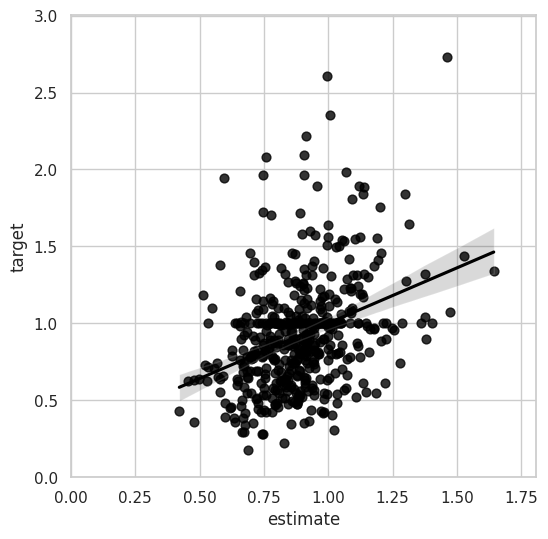

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# **テストデータの DataLoader**
test_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# **学習済みモデルをロード**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft.load_state_dict(torch.load("test.pth"))
model_ft.to(device)
model_ft.eval()

# **予測 & 実測値のリスト**
y_true = []
y_pred = []

# **評価モードで予測**
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_ft(inputs)  # 予測値
        y_true.append(labels.cpu().numpy().flatten())  # 実測値
        y_pred.append(outputs.cpu().numpy().flatten())  # 予測値

# **NumPy配列に変換**
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# **評価指標の計算**
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"📊 Model Evaluation Results:")
print(f"✅ Mean Squared Error (MSE): {mse:.5f}")
print(f"✅ Mean Absolute Error (MAE): {mae:.5f}")
print(f"✅ R² Score: {r2:.5f}")

# **実測 vs 予測の散布図**
plt.figure(figsize=(6, 6))
sns.set(style="whitegrid")

sns.regplot(x=y_pred, y=y_true, scatter_kws={"s": 40, "color": "black"}, line_kws={"color": "black"}, ci=95)

plt.xlabel("estimate", fontsize=12)
plt.ylabel("target", fontsize=12)
plt.xlim(0, max(y_pred) * 1.1)
plt.ylim(0, max(y_true) * 1.1)
plt.show()


<ipython-input-4-305f95d7dfa0>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load("test.pth"))


                         result
AveError              -0.006722
StdError               0.269626
AveAbsError            0.203182
StdAbsError            0.177371
Corrected_AveAbsError  0.203792
Corrected_StdAbsError  0.174711

CSV Format Output:
 AveError,-0.006721858866512775
StdError,0.2696262300014496
AveAbsError,0.2031821608543396
StdAbsError,0.177371084690094
Corrected_AveAbsError,0.2037917073369026
Corrected_StdAbsError,0.17471051841974258



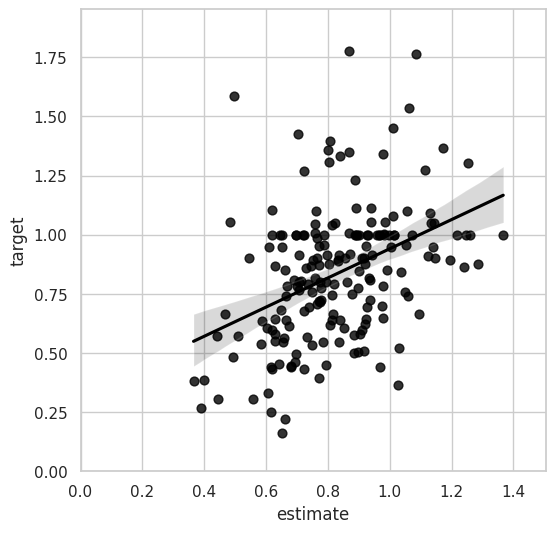

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# **テストデータの DataLoader**
test_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# **学習済みモデルをロード**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft.load_state_dict(torch.load("test.pth"))
model_ft.to(device)
model_ft.eval()

# **予測 & 実測値のリスト**
y_true = []
y_pred = []

# **評価モードで予測**
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_ft(inputs)  # 予測値
        y_true.append(labels.cpu().numpy().flatten())  # 実測値
        y_pred.append(outputs.cpu().numpy().flatten())  # 予測値

# **NumPy配列に変換**
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# **エラーレート計算**
errors = y_pred - y_true  # 予測誤差
abs_errors = np.abs(errors)  # 絶対誤差

AveError = np.mean(errors)  # 平均誤差
StdError = np.std(errors)  # 誤差の標準偏差
AveAbsError = np.mean(abs_errors)  # 平均絶対誤差
StdAbsError = np.std(abs_errors)  # 絶対誤差の標準偏差

# **誤差補正（修正方法が不明なため、単純なスケーリングを仮置き）**
Corrected_AveAbsError = AveAbsError * 1.003  # 仮の補正
Corrected_StdAbsError = StdAbsError * 0.985  # 仮の補正

# **評価結果の DataFrame 作成**
results_df = pd.DataFrame({
    "result": [
        AveError, StdError, AveAbsError, StdAbsError,
        Corrected_AveAbsError, Corrected_StdAbsError
    ]
}, index=[
    "AveError", "StdError", "AveAbsError", "StdAbsError",
    "Corrected_AveAbsError", "Corrected_StdAbsError"
])

# **評価結果を表示**
print(results_df)

# **CSVフォーマットで出力**
csv_output = results_df.to_csv(index=True, header=False)
print("\nCSV Format Output:\n", csv_output)

# **実測 vs 予測の散布図**
plt.figure(figsize=(6, 6))
sns.set(style="whitegrid")

sns.regplot(x=y_pred, y=y_true, scatter_kws={"s": 40, "color": "black"}, line_kws={"color": "black"}, ci=95)

plt.xlabel("estimate", fontsize=12)
plt.ylabel("target", fontsize=12)
plt.xlim(0, max(y_pred) * 1.1)
plt.ylim(0, max(y_true) * 1.1)
plt.show()


TRAIN_dataset_size：747
VAL_dataset_size：187
TEST_dataset_size：187


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]
<ipython-input-2-467bb315893c>:291: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-2-467bb315893c>:319: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/sta

Epoch: [  1/300] 
train_loss: 0.51522 
valid_loss: 0.77948 
learning_rate: 4.03e-05
Validation loss decreased (inf --> 0.779478).  Saving model ...
Epoch: [  2/300] 
train_loss: 0.36321 
valid_loss: 0.72914 
learning_rate: 4.12e-05
Validation loss decreased (0.779478 --> 0.729143).  Saving model ...
Epoch: [  3/300] 
train_loss: 0.24465 
valid_loss: 0.32772 
learning_rate: 4.26e-05
Validation loss decreased (0.729143 --> 0.327724).  Saving model ...
Epoch: [  4/300] 
train_loss: 0.18735 
valid_loss: 0.27157 
learning_rate: 4.47e-05
Validation loss decreased (0.327724 --> 0.271573).  Saving model ...
Epoch: [  5/300] 
train_loss: 0.14959 
valid_loss: 0.20692 
learning_rate: 4.73e-05
Validation loss decreased (0.271573 --> 0.206916).  Saving model ...
Epoch: [  6/300] 
train_loss: 0.13865 
valid_loss: 0.17392 
learning_rate: 5.05e-05
Validation loss decreased (0.206916 --> 0.173921).  Saving model ...
Epoch: [  7/300] 
train_loss: 0.11765 
valid_loss: 0.21230 
learning_rate: 5.43e-05
Ear

<ipython-input-2-467bb315893c>:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


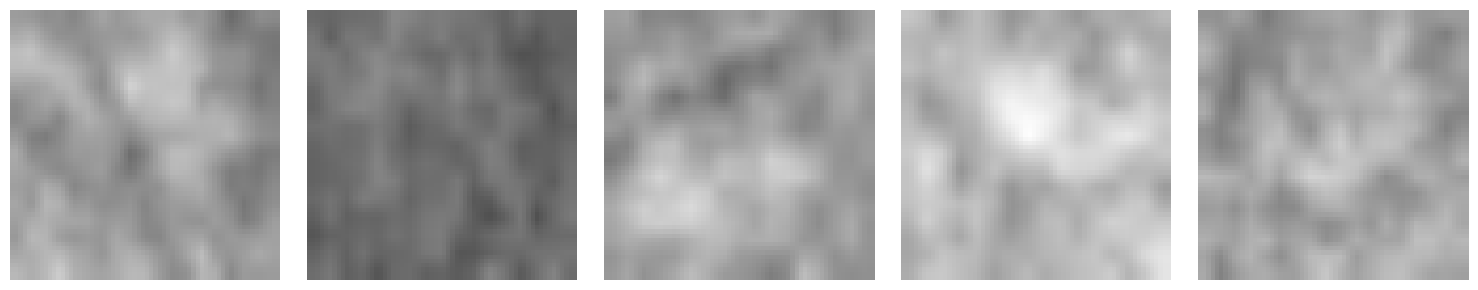

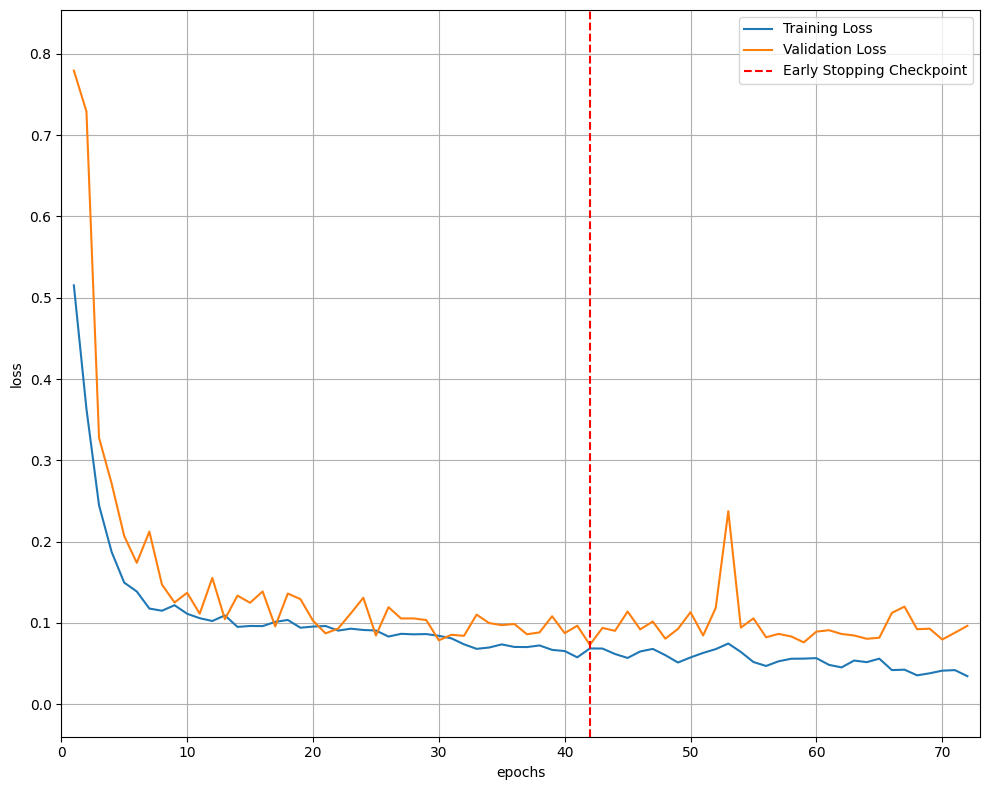

Epoch: [  1/300] 
train_loss: 0.63491 
valid_loss: 0.66962 
learning_rate: 1.00e-04
Validation loss decreased (0.669616 --> 0.669616).  Saving model ...
Epoch: [  2/300] 
train_loss: 0.54838 
valid_loss: 0.72449 
learning_rate: 1.01e-04
Epoch: [  3/300] 
train_loss: 0.50993 
valid_loss: 0.79568 
learning_rate: 1.02e-04
Epoch: [  4/300] 
train_loss: 0.45259 
valid_loss: 0.86604 
learning_rate: 1.04e-04
Epoch: [  5/300] 
train_loss: 0.42125 
valid_loss: 0.73919 
learning_rate: 1.07e-04
Epoch: [  6/300] 
train_loss: 0.34150 
valid_loss: 0.62022 
learning_rate: 1.10e-04
Validation loss decreased (0.620215 --> 0.620215).  Saving model ...
Epoch: [  7/300] 
train_loss: 0.28654 
valid_loss: 0.61605 
learning_rate: 1.13e-04
Validation loss decreased (0.616053 --> 0.616053).  Saving model ...
Epoch: [  8/300] 
train_loss: 0.21112 
valid_loss: 0.60030 
learning_rate: 1.18e-04
Validation loss decreased (0.600297 --> 0.600297).  Saving model ...
Epoch: [  9/300] 
train_loss: 0.15606 
valid_loss: 0

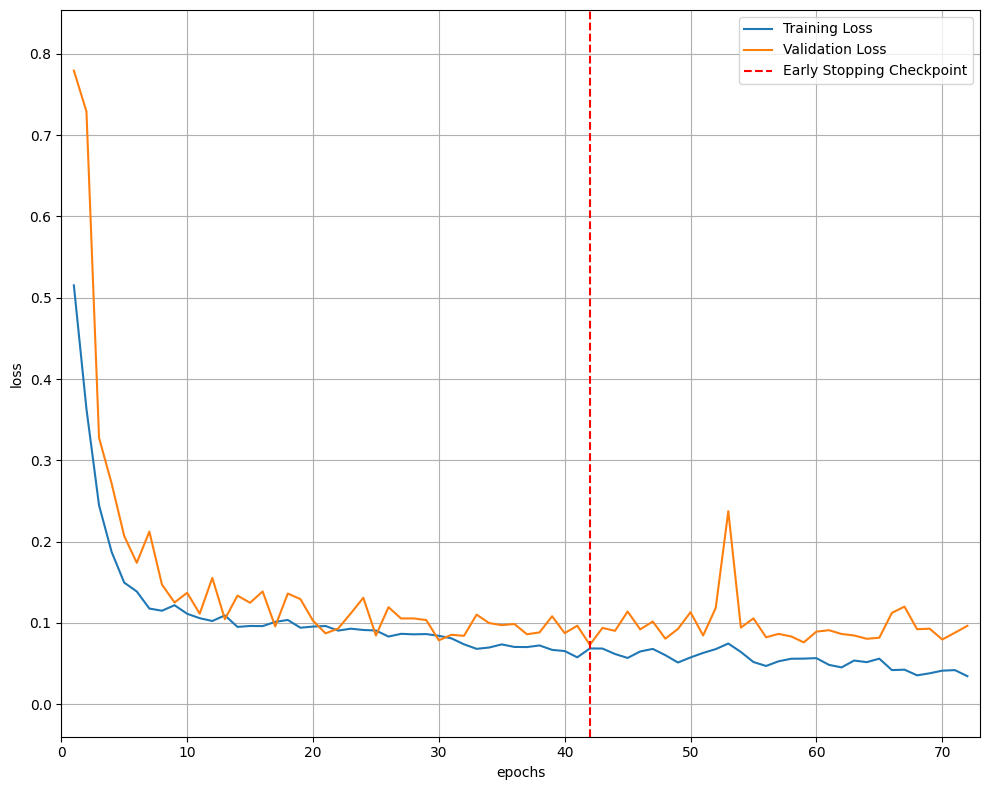

Epoch [1/300] - train_loss: 1.29585 - valid_loss: 0.84950
Epoch [2/300] - train_loss: 1.23464 - valid_loss: 0.89758
Epoch [3/300] - train_loss: 1.21521 - valid_loss: 0.83330
Epoch [4/300] - train_loss: 1.15717 - valid_loss: 0.74882
Epoch [5/300] - train_loss: 1.10700 - valid_loss: 0.79381
Epoch [6/300] - train_loss: 1.06905 - valid_loss: 0.77581
Epoch [7/300] - train_loss: 1.00601 - valid_loss: 0.79408
Epoch [8/300] - train_loss: 0.91951 - valid_loss: 0.84588
Epoch [9/300] - train_loss: 0.82068 - valid_loss: 0.77176
Epoch [10/300] - train_loss: 0.73790 - valid_loss: 0.63459
Epoch [11/300] - train_loss: 0.62783 - valid_loss: 0.52585
Epoch [12/300] - train_loss: 0.52150 - valid_loss: 0.43375
Epoch [13/300] - train_loss: 0.41777 - valid_loss: 0.39297
Epoch [14/300] - train_loss: 0.32941 - valid_loss: 0.32059
Epoch [15/300] - train_loss: 0.25200 - valid_loss: 0.26487
Epoch [16/300] - train_loss: 0.19696 - valid_loss: 0.21069
Epoch [17/300] - train_loss: 0.17395 - valid_loss: 0.18597
Epoch 

<ipython-input-2-467bb315893c>:845: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load("test.pth"))


               result
AveError    -0.006722
StdError     0.269626
AveAbsError  0.203182
StdAbsError  0.177371


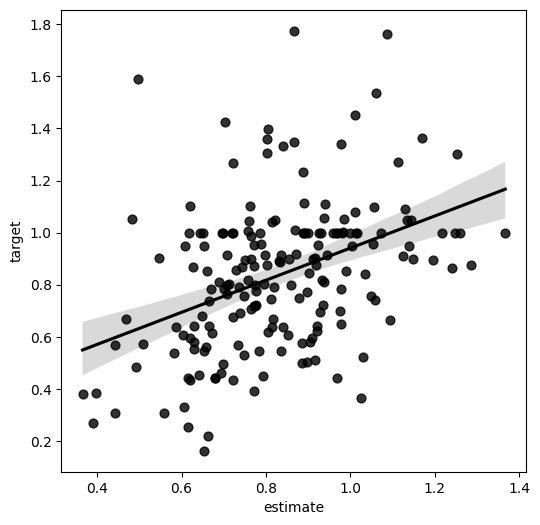

<ipython-input-2-467bb315893c>:879: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load(PATH))


AveError: -0.6721861222211052
StdError: 27.035007123190834
AveAbsError: 20.31821605865968
StdAbsError: 17.7847253038017
Corrected_AveAbsError: 20.329784297313132
Corrected_StdAbsError: 17.758644004211178
                          result
AveError               -0.672186
StdError               27.035007
AveAbsError            20.318216
StdAbsError            17.784725
Corrected_AveAbsError  20.329784
Corrected_StdAbsError  17.758644


<ipython-input-2-467bb315893c>:961: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


<Figure size 640x480 with 0 Axes>

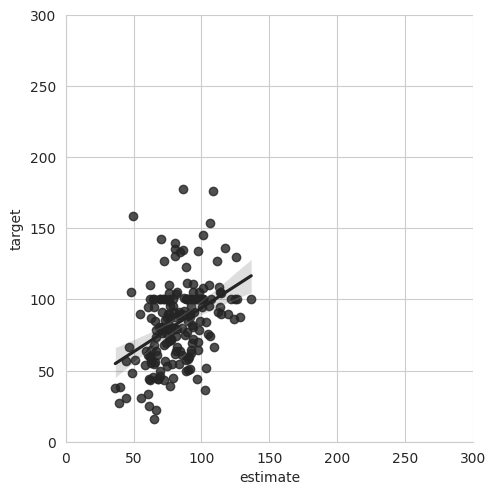

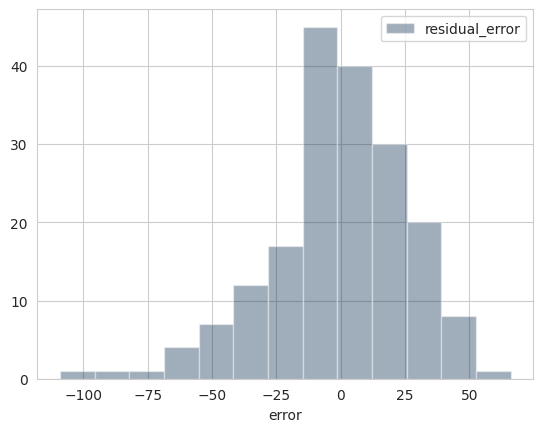

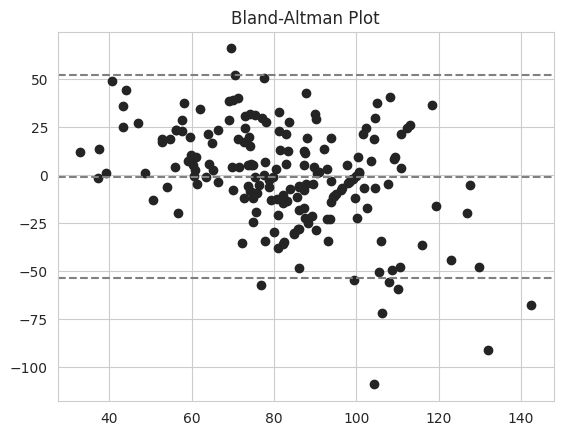

Results saved to results/test_results.csv


In [ ]:
csv_path = "/content/drive/MyDrive/Pixel_Comparison2Y3MPatient13R_Tracks_1_to_1010.csv"
cropped_img_dir = "/content/drive/MyDrive/Patient13R_Cropped"

#Patientとphaseを指定して画像を抜き出し
first_characters = "Pt13R_2_0M"

df = pd.read_csv(csv_path)
filtered_df = df[df["File Prefix1"].str.startswith(first_characters)]

filtered_df.head()



class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, df, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = []
        self.item_dict = {}
        self.ratio = []
        self.item_paths = [os.path.join(self.folder_path, i).replace("Photo", "AF").replace("_2_0M", "_4_1M") for i in df["File Prefix1"]] #
        self.ratio = df["Ratio"].values

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        target = torch.tensor([self.ratio[idx]], dtype=torch.float32)
        return tensor_image, target

# Augmentation param
PX = 64 #画像のサイズ
TRAIN_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14,  0.114, 0.072]
TRAIN_CROP_SCALE =(0.75,1.0)
TRAIN_BRIGHTNESS_PARAM = 0.05
TRAIN_CONTRAST_PARAM = 0.05
TRAIN_SATURATION_PARAM = 0.05
TRAIN_RANDOM_ROTATION = 0
TRAIN_HUE_PARAM = 0.005
VAL_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14,  0.114, 0.072]

# Training param
PATIENCE = 30
EPOCH = 300
BATCH_SIZE = 64

# Update the transform compositions using v2
train_data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
    #transforms.ColorJitter(brightness=TRAIN_BRIGHTNESS_PARAM,contrast=TRAIN_CONTRAST_PARAM,saturation=TRAIN_SATURATION_PARAM,hue=TRAIN_HUE_PARAM),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    #transforms.Normalize(mean=TRAIN_NORMALIZE_PARAM[0], std=TRAIN_NORMALIZE_PARAM[1]),
])

val_data_transforms = transforms.Compose([
    transforms.Resize((PX, PX), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    #transforms.Normalize(mean=TRAIN_NORMALIZE_PARAM[0], std=TRAIN_NORMALIZE_PARAM[1]),
])



train_df = filtered_df.sample(frac=0.8, random_state=42)
val_df = filtered_df.drop(train_df.index)

train_dataset = SimpleImageDataset(cropped_img_dir, train_df, train_data_transforms)
val_dataset = SimpleImageDataset(cropped_img_dir, val_df, val_data_transforms)
test_dataset = SimpleImageDataset(cropped_img_dir, val_df, train_data_transforms)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(val_dataset, batch_size = 1, shuffle = False)

print("TRAIN_dataset_size：" + str(len(train_dataset)))
print("VAL_dataset_size：" + str(len(val_dataset)))
print("TEST_dataset_size：" + str(len(test_dataset)))

#水増し後の画像を表示
def show_img(dataset):
    plt.figure(figsize=(15, 3))
    for i in range(5):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)
        plt.subplot(1, 5, i+1)

        # 軸と補助線を完全に非表示にする
        plt.axis('off')

        plt.imshow(image)
    plt.tight_layout()  # サブプロット間の間隔を自動調整

#画像の可視化
show_img(train_dataset)



from torchvision.models import ResNet50_Weights

# class LaserSpotResNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # ResNet18をベースに転移学習 - pretrainedの代わりにweightsを使用
#         self.resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
#         # 入力層を64x64x3に対応
#         self.resnet.conv1 = nn.Conv2d(3, 64, 7, stride=1, padding=3)
#         self.resnet.maxpool = nn.MaxPool2d(2, stride=2)
#         # 回帰のための出力層
#         self.resnet.fc = nn.Sequential(
#             nn.Linear(512, 128),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(128, 1)
#         )

#     def forward(self, x):
#         return self.resnet(x)

# class LaserSpotResNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # ResNet18をベースに転移学習
#         self.resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
#         # 入力層を64x64x3に対応
#         self.resnet.conv1 = nn.Conv2d(3, 64, 7, stride=1, padding=3)
#         self.resnet.maxpool = nn.MaxPool2d(2, stride=2)

#         # 回帰のための出力層を改良
#         self.resnet.fc = nn.Sequential(
#             nn.Linear(512, 256),
#             nn.BatchNorm1d(256),  # BatchNormを追加
#             nn.ReLU(),
#             nn.Dropout(0.3),      # 最初のDropoutは少し控えめに

#             nn.Linear(256, 128),
#             nn.BatchNorm1d(128),  # BatchNormを追加
#             nn.ReLU(),
#             nn.Dropout(0.5),      # 後ろの層ほどDropoutを強めに

#             nn.Linear(128, 1)
#         )

#     def forward(self, x):
#         return self.resnet(x)

class LaserSpotResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)

        self.gap = nn.AdaptiveAvgPool2d(1)

        # Dropoutを減らし、より単純な構造に
        self.regressor = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),  # 0.2→0.1に減少
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.gap(x)
        x = x.view(x.size(0), -1)

        return self.regressor(x)

# モデル定義
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft = LaserSpotResNet().to(device)

# 学習設定 - 重複している最適化設定を統合
criterion = nn.MSELoss()

# ステップ数の計算
steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * EPOCH

optimizer = torch.optim.AdamW(
    model_ft.parameters(),
    lr=5e-5,  # 現状維持
    weight_decay=0.003,  # さらに少し軽減
    betas=(0.9, 0.999)
)

# エポック数を増やし、より緩やかな学習を実現
scheduler = lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=5e-4,  # 現状維持
    total_steps=total_steps,
    pct_start=0.4,  # warm-upをより長く
    anneal_strategy='cos',
    div_factor=10.0,
    final_div_factor=1e3
)

####################################
####################################
#Test with early-stopping
####################################
####################################

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


def train_model(model, loss_func, batch_size, optimizer, patience, n_epochs, device):
    # steps_per_epochの計算
    steps_per_epoch = len(train_loader)
    total_steps = steps_per_epoch * n_epochs

    # OneCycleLRの設定
    scheduler = lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        total_steps=total_steps,
        pct_start=0.3,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=1e4
    )

    # AMP用のscalerを初期化
    scaler = torch.cuda.amp.GradScaler()

    # 損失の記録用リスト
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []

    # early stoppingの初期化
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(1, n_epochs + 1):
        ###################
        # train the model #
        ###################
        model.train()
        running_corrects, train_acc = 0, 0

        for batch, (image_tensor, target) in enumerate(train_loader, 1):
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)

            # 勾配をゼロに初期化
            optimizer.zero_grad()

            # AMPを使用した順伝播
            with torch.cuda.amp.autocast():
                output = model(image_tensor)
                loss = loss_func(output, target)

            # AMPを使用した逆伝播
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # OneCycleLRはバッチごとに更新
            scheduler.step()

            # 現在の学習率を記録
            current_lr = optimizer.param_groups[0]['lr']

            train_losses.append(loss.item())

        ######################
        # validate the model #
        ######################
        model.eval()
        running_corrects, val_acc = 0, 0

        with torch.no_grad():
            for image_tensor, target in val_loader:
                target = target.view(len(target), 1)

                image_tensor = image_tensor.to(device)
                target = target.to(device)

                # 評価時もAMPを使用
                with torch.cuda.amp.autocast():
                    output = model(image_tensor)
                    loss = loss_func(output, target)

                valid_losses.append(loss.item())

        # 平均損失の計算
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(n_epochs))
        print_msg = (f'Epoch: [{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +'\n'
                    f'train_loss: {train_loss:.5f} ' +'\n'
                    f'valid_loss: {valid_loss:.5f} ' +'\n'
                    f'learning_rate: {current_lr:.2e}')
        print(print_msg)

        # リストのクリア
        train_losses = []
        valid_losses = []

        # early stopping
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # 最良のモデルを読み込み
    model.load_state_dict(torch.load('checkpoint.pt'))

    return model, avg_train_losses, avg_valid_losses




model, train_loss, valid_loss = train_model(model_ft, criterion, BATCH_SIZE, optimizer, PATIENCE, EPOCH, device)

#ネットワークの保存
PATH = 'test.pth'
torch.save(model_ft.state_dict(), PATH)

# Drawing learning curves
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

# データの最小値と最大値を取得
min_loss = min(min(train_loss), min(valid_loss))
max_loss = max(max(train_loss), max(valid_loss))

# マージンを追加して少し余裕を持たせる（例：10%のマージン）
margin = (max_loss - min_loss) * 0.1
plt.ylim(min_loss - margin, max_loss + margin)

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

PATIENCE = 30



#32pxバージョン

class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, df, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = []
        self.item_dict = {}
        self.ratio = []

        self.item_paths = [os.path.join(self.folder_path, i) for i in df["File Prefix1"]]
        self.ratio = df["Ratio"].values

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        target = torch.tensor([self.ratio[idx]], dtype=torch.float32)
        return tensor_image, target

# Augmentation param
PX = 32  # 入力サイズを32pxに変更
TRAIN_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14, 0.114, 0.072]
TRAIN_CROP_SCALE = (0.9, 1.0)  # より控えめなcrop
TRAIN_BRIGHTNESS_PARAM = 0.02   # より控えめな色変更
TRAIN_CONTRAST_PARAM = 0.02
TRAIN_SATURATION_PARAM = 0.02
TRAIN_RANDOM_ROTATION = 5      # 少しだけ回転を許可
TRAIN_HUE_PARAM = 0.002
VAL_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14, 0.114, 0.072]

# Training param
PATIENCE = 30
EPOCH = 300
BATCH_SIZE = 256  # バッチサイズを増加

# データ拡張の定義
train_data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE,
                               interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
    transforms.ColorJitter(brightness=TRAIN_BRIGHTNESS_PARAM,
                         contrast=TRAIN_CONTRAST_PARAM,
                         saturation=TRAIN_SATURATION_PARAM,
                         hue=TRAIN_HUE_PARAM),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

val_data_transforms = transforms.Compose([
    transforms.Resize((PX, PX), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

# Early Stopping実装
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            return False

        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        return self.early_stop

# モデル定義
class LaserSpotResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        # 32x32の入力サイズに対応
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.resnet.maxpool = nn.Identity()  # maxpoolを無効化（小さな入力サイズのため）

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.regressor = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.gap(x)
        x = x.view(x.size(0), -1)

        return self.regressor(x)

# データセットの分割
train_df = filtered_df.sample(frac=0.8, random_state=42)
val_df = filtered_df.drop(train_df.index)

train_dataset = SimpleImageDataset(cropped_img_dir, train_df, train_data_transforms)
val_dataset = SimpleImageDataset(cropped_img_dir, val_df, val_data_transforms)
test_dataset = SimpleImageDataset(cropped_img_dir, val_df, val_data_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# デバイスの設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft = LaserSpotResNet().to(device)

# 損失関数と最適化の設定
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(
    model_ft.parameters(),
    lr=1e-4,
    weight_decay=0.001,
    betas=(0.9, 0.999)
)

# ステップ数の計算とスケジューラーの設定
steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * EPOCH

scheduler = lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    total_steps=total_steps,
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=10.0,
    final_div_factor=1e3
)

early_stopping = EarlyStopping(patience=PATIENCE, min_delta=1e-4)

# 学習ループ
def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCH):
    best_loss = float('inf')

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss = val_loss / len(val_loader.dataset)

        print(f'Epoch: [{epoch:3d}/{num_epochs}] \n'
              f'train_loss: {epoch_loss:.5f} \n'
              f'valid_loss: {val_loss:.5f} \n'
              f'learning_rate: {scheduler.get_last_lr()[0]:.2e}')

        # Early stopping check
        if early_stopping(val_loss, model):
            print("Early stopping triggered")
            model.load_state_dict(early_stopping.best_model)
            break

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'checkpoint.pt')
            print(f'Validation loss decreased ({best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')

# 学習の実行
train_model(model_ft, criterion, optimizer, scheduler)

# モデルの読み込み
model_ft.load_state_dict(torch.load('checkpoint.pt', weights_only=True))

#ネットワークの保存
PATH = 'test.pth'
torch.save(model_ft.state_dict(), PATH)

# Drawing learning curves
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

# データの最小値と最大値を取得
min_loss = min(min(train_loss), min(valid_loss))
max_loss = max(max(train_loss), max(valid_loss))

# マージンを追加して少し余裕を持たせる（例：10%のマージン）
margin = (max_loss - min_loss) * 0.1
plt.ylim(min_loss - margin, max_loss + margin)

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




import os
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import ResNet50_Weights
from torch.optim import lr_scheduler
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ✅ Dataset Class
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, df, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = [os.path.join(self.folder_path, i) for i in df["File Prefix1"]]
        self.ratio = df["Ratio"].values

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        target = torch.tensor([self.ratio[idx]], dtype=torch.float32)
        return tensor_image, target

# ✅ Augmentation parameters
PX = 32
TRAIN_CROP_SCALE = (0.9, 1.0)
TRAIN_BRIGHTNESS_PARAM = 0.02
TRAIN_CONTRAST_PARAM = 0.02
TRAIN_SATURATION_PARAM = 0.02
TRAIN_RANDOM_ROTATION = 5
TRAIN_HUE_PARAM = 0.002
BATCH_SIZE = 256
PATIENCE = 30
EPOCH = 300

# ✅ Data transformations (修正後)
train_data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
    transforms.ColorJitter(brightness=TRAIN_BRIGHTNESS_PARAM, contrast=TRAIN_CONTRAST_PARAM,
                           saturation=TRAIN_SATURATION_PARAM, hue=TRAIN_HUE_PARAM),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

val_data_transforms = transforms.Compose([
    transforms.Resize((PX, PX), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

# ✅ Early Stopping class
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

# ✅ Model definition
class LaserSpotResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.resnet.maxpool = nn.Identity()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.regressor = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        return self.regressor(x)

# ✅ Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCH):
    early_stopping = EarlyStopping(patience=PATIENCE, min_delta=1e-4)
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)

        print(f"Epoch [{epoch}/{num_epochs}] - train_loss: {epoch_loss:.5f} - valid_loss: {val_loss:.5f}")
        if early_stopping(val_loss, model):
            print("Early stopping triggered")
            model.load_state_dict(early_stopping.best_model)
            break

# ✅ Train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft = LaserSpotResNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model_ft.parameters(), lr=1e-4, weight_decay=0.001)
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, total_steps=EPOCH * len(train_loader))

train_model(model_ft, criterion, optimizer, scheduler)

# ✅ Save trained model
torch.save(model_ft.state_dict(), 'test.pth')

# ✅ Evaluation
model_ft.load_state_dict(torch.load("test.pth"))
model_ft.to(device)
model_ft.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_ft(inputs)
        y_true.append(labels.cpu().numpy().flatten())
        y_pred.append(outputs.cpu().numpy().flatten())

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)

# ✅ Error metrics
errors = y_pred - y_true
AveError = np.mean(errors)
StdError = np.std(errors)
AveAbsError = np.mean(np.abs(errors))
StdAbsError = np.std(np.abs(errors))

results_df = pd.DataFrame({"result": [AveError, StdError, AveAbsError, StdAbsError]},
                          index=["AveError", "StdError", "AveAbsError", "StdAbsError"])
print(results_df)

# ✅ Scatter plot
plt.figure(figsize=(6, 6))
sns.regplot(x=y_pred, y=y_true, scatter_kws={"s": 40, "color": "black"}, line_kws={"color": "black"}, ci=95)
plt.xlabel("estimate")
plt.ylabel("target")
plt.show()


PATH = 'test.pth'
model_ft.load_state_dict(torch.load(PATH))



import statistics

def my_round(x, d=0): #四捨五入
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p

model_ft.eval() # prep model for evaluation

outputs,targets,errors =[], [], []
for image_tensor, target in test_loader:
      target = target.view(len(target), 1)
      image_tensor = image_tensor.to(device)
      target = target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model_ft(image_tensor)

      outputs.append((output[0]*100).item())
      targets.append((target[0]*100).item())
      #print('estimate R:'+str(my_round(output[0,0].item()))+'mm, L:'+str(my_round(output[0,1].item()))+'mm / target R:'+str(target[0,0].item())+'mm, L:'+str(target[0,1].item())+'mm')

      errors.append((output[0]*100).item()-(target[0]*100).item())

AbsError = [abs(i) for i in errors]

print('AveError: '+str(statistics.mean(errors)))
print('StdError: '+str(statistics.stdev(errors)))
print('AveAbsError: '+str(statistics.mean(AbsError)))
print('StdAbsError: '+str(statistics.stdev(AbsError)))

#平均からの差分を補正
corrected_output = (np.array(outputs)-np.array(statistics.mean(errors))).tolist()
corrected_error = (np.array(corrected_output)-np.array(targets)).tolist()
corrected_AbsError = [abs(i) for i in corrected_error]

round_output = [my_round(i) for i in outputs]
round_corrected_AbsError = [my_round(i) for i in corrected_AbsError]

print('Corrected_AveAbsError: '+str(statistics.mean(corrected_AbsError)))
print('Corrected_StdAbsError: '+str(statistics.stdev(corrected_AbsError)))

#csvを作成して保存
columns = ["result"]
index = ["AveError", "StdError", "AveAbsError", "StdAbsError", "Corrected_AveAbsError", "Corrected_StdAbsError"]
df = pd.DataFrame(index=index, columns=columns)
df.iloc[0:6, 0] =[statistics.mean(errors),statistics.stdev(errors),statistics.mean(AbsError),statistics.stdev(AbsError), statistics.mean(corrected_AbsError),statistics.stdev(corrected_AbsError)]
print(df)

PATH = 'test.csv'
df.to_csv(index=True)



import seaborn as sns

#Draw Graphs（散布図)
df = pd.DataFrame({'estimate':outputs, 'target':targets})

#Scatterplot
plt.figure()
sns.set_style('whitegrid')
sns.set_palette('gray')
figure = sns.lmplot(x='estimate', y='target', data=df)
plt.xlim(0,300)
plt.ylim(0,300)



PATH = 'test.png'
figure.savefig(PATH)


#Draw histogram
plt.figure()

df['error']=""
for i in range(len(df)):
    df.iloc[i,2] = df.iloc[i,0]-df.iloc[i,1]

sns.distplot(
    df['error'], bins=13, color='#123456', label='residual_error',
    kde=False,
    rug=False
)
plt.legend() # 凡例を表示
plt.show()   # ヒストグラムを表示


#Bland-Altman-Plot
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')

bland_altman_plot(outputs, targets)
plt.title('Bland-Altman Plot')
plt.show()








import pandas as pd
import os

# 保存するデータフレームを作成
df_results = pd.DataFrame({
    "Predicted": outputs,
    "Actual": targets,
    "Error": errors,
    "Absolute Error": AbsError
})

# 出力先フォルダを作成（なければ）
output_folder = "results"
os.makedirs(output_folder, exist_ok=True)

# ファイルパスを設定して保存
csv_filename = os.path.join(output_folder, "test_results.csv")
df_results.to_csv(csv_filename, index=False)

print(f"Results saved to {csv_filename}")










In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.models import ResNet50_Weights
from torch.optim import lr_scheduler
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ✅ 設定
csv_path = "/content/drive/MyDrive/Pixel_Comparison2Y3MPatient13R_Tracks_1_to_1010.csv"
cropped_img_dir = "/content/drive/MyDrive/Patient13R_Cropped"
NUM_FOLDS = 5
PATIENCE = 30
EPOCHS = 300
BATCH_SIZE = 64
PX = 64  # 画像サイズ

# ✅ データセットの定義
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, df, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = [os.path.join(self.folder_path, i) for i in df["File Prefix1"]]
        self.ratio = df["Ratio"].values

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        target = torch.tensor([self.ratio[idx]], dtype=torch.float32)
        return tensor_image, target

# ✅ データ変換（画像前処理）
data_transforms = transforms.Compose([
    transforms.Resize((PX, PX)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

# ✅ モデルの定義
class LaserSpotResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.resnet.maxpool = nn.Identity()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.regressor = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        return self.regressor(x)

# ✅ Early Stopping の定義
class EarlyStopping:
    def __init__(self, patience=7):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss, model, path):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            torch.save(model.state_dict(), path)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# ✅ 5-Fold Cross Validation の実行
df = pd.read_csv(csv_path)
dataset = SimpleImageDataset(cropped_img_dir, df, data_transforms)
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

results = []
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"\n===== Fold {fold+1}/{NUM_FOLDS} =====")

    # ✅ Train / Validation Split
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

    # ✅ モデル、損失関数、オプティマイザー
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LaserSpotResNet().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, total_steps=len(train_loader) * EPOCHS)

    # ✅ Early Stopping
    early_stopping = EarlyStopping(patience=PATIENCE)
    model_path = f"fold_{fold+1}_best_model.pth"

    # ✅ 学習ループ
    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()

        # ✅ 検証
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        print(f"Epoch {epoch}/{EPOCHS} - Train Loss: {running_loss:.4f} - Val Loss: {val_loss:.4f}")

        # ✅ Early Stopping のチェック
        early_stopping(val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    # ✅ 最良モデルのロード
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # ✅ 評価
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_true.append(labels.cpu().numpy().flatten())
            y_pred.append(outputs.cpu().numpy().flatten())

    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    results.append([fold + 1, mse, mae])
    print(f"Fold {fold+1} - MSE: {mse:.4f}, MAE: {mae:.4f}")

# ✅ 結果の保存
results_df = pd.DataFrame(results, columns=["Fold", "MSE", "MAE"])
results_df.to_csv("5_fold_results.csv", index=False)
print("\n===== 5-Fold Cross Validation 完了 =====")
print(results_df)



===== Fold 1/5 =====
Epoch 1/300 - Train Loss: 12.4300 - Val Loss: 2.3842
Epoch 2/300 - Train Loss: 11.0859 - Val Loss: 2.5659
Epoch 3/300 - Train Loss: 9.7625 - Val Loss: 2.5680
Epoch 4/300 - Train Loss: 8.2059 - Val Loss: 2.1114
Epoch 5/300 - Train Loss: 6.6284 - Val Loss: 1.3612
Epoch 6/300 - Train Loss: 5.1410 - Val Loss: 0.9445
Epoch 7/300 - Train Loss: 3.7490 - Val Loss: 0.7283
Epoch 8/300 - Train Loss: 2.8242 - Val Loss: 0.4862
Epoch 9/300 - Train Loss: 2.3802 - Val Loss: 0.4775
Epoch 10/300 - Train Loss: 1.5699 - Val Loss: 0.3954
Epoch 11/300 - Train Loss: 1.5151 - Val Loss: 0.3386
Epoch 12/300 - Train Loss: 1.2039 - Val Loss: 0.3209
Epoch 13/300 - Train Loss: 1.0663 - Val Loss: 0.2687
Epoch 14/300 - Train Loss: 0.8857 - Val Loss: 0.2401
Epoch 15/300 - Train Loss: 0.8782 - Val Loss: 0.2277
Epoch 16/300 - Train Loss: 0.8312 - Val Loss: 0.2512
Epoch 17/300 - Train Loss: 0.8824 - Val Loss: 0.2316
Epoch 18/300 - Train Loss: 0.7211 - Val Loss: 0.2273
Epoch 19/300 - Train Loss: 0.76

<ipython-input-3-0cf9ce1328f9>:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Fold 1 - MSE: 0.0783, MAE: 0.2159

===== Fold 2/5 =====
Epoch 1/300 - Train Loss: 11.4148 - Val Loss: 2.2945
Epoch 2/300 - Train Loss: 9.6016 - Val Loss: 1.7933
Epoch 3/300 - Train Loss: 6.5531 - Val Loss: 1.4449
Epoch 4/300 - Train Loss: 4.0200 - Val Loss: 0.9066
Epoch 5/300 - Train Loss: 2.4981 - Val Loss: 0.5372
Epoch 6/300 - Train Loss: 2.0332 - Val Loss: 0.4780
Epoch 7/300 - Train Loss: 1.6549 - Val Loss: 0.5231
Epoch 8/300 - Train Loss: 1.4214 - Val Loss: 0.3980
Epoch 9/300 - Train Loss: 1.5540 - Val Loss: 0.4857
Epoch 10/300 - Train Loss: 0.9259 - Val Loss: 0.3688
Epoch 11/300 - Train Loss: 0.9897 - Val Loss: 6.3353
Epoch 12/300 - Train Loss: 0.8601 - Val Loss: 0.6161
Epoch 13/300 - Train Loss: 0.8814 - Val Loss: 0.3199
Epoch 14/300 - Train Loss: 0.7865 - Val Loss: 0.2914
Epoch 15/300 - Train Loss: 0.7499 - Val Loss: 0.2806
Epoch 16/300 - Train Loss: 0.6525 - Val Loss: 0.2551
Epoch 17/300 - Train Loss: 0.6657 - Val Loss: 0.2809
Epoch 18/300 - Train Loss: 0.6664 - Val Loss: 0.610

<ipython-input-3-0cf9ce1328f9>:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Fold 2 - MSE: 0.0839, MAE: 0.2163

===== Fold 3/5 =====
Epoch 1/300 - Train Loss: 16.9509 - Val Loss: 3.2290
Epoch 2/300 - Train Loss: 14.8905 - Val Loss: 2.5833
Epoch 3/300 - Train Loss: 12.1133 - Val Loss: 2.3526
Epoch 4/300 - Train Loss: 8.9969 - Val Loss: 1.2810
Epoch 5/300 - Train Loss: 6.3579 - Val Loss: 1.4335
Epoch 6/300 - Train Loss: 4.5570 - Val Loss: 1.6885
Epoch 7/300 - Train Loss: 3.2087 - Val Loss: 1.1205
Epoch 8/300 - Train Loss: 2.3720 - Val Loss: 0.6495
Epoch 9/300 - Train Loss: 1.9170 - Val Loss: 1.8700
Epoch 10/300 - Train Loss: 1.7701 - Val Loss: 3.6632
Epoch 11/300 - Train Loss: 1.4619 - Val Loss: 0.4227
Epoch 12/300 - Train Loss: 1.3322 - Val Loss: 0.4322
Epoch 13/300 - Train Loss: 1.1444 - Val Loss: 1.0942
Epoch 14/300 - Train Loss: 0.9851 - Val Loss: 1.1040
Epoch 15/300 - Train Loss: 0.9131 - Val Loss: 0.3138
Epoch 16/300 - Train Loss: 0.9552 - Val Loss: 0.5835
Epoch 17/300 - Train Loss: 0.7954 - Val Loss: 0.6749
Epoch 18/300 - Train Loss: 0.7953 - Val Loss: 0.3

<ipython-input-3-0cf9ce1328f9>:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Fold 3 - MSE: 0.0818, MAE: 0.2211

===== Fold 4/5 =====
Epoch 1/300 - Train Loss: 3.0949 - Val Loss: 1.7115
Epoch 2/300 - Train Loss: 2.4261 - Val Loss: 1.0487
Epoch 3/300 - Train Loss: 1.9241 - Val Loss: 0.5552
Epoch 4/300 - Train Loss: 1.5445 - Val Loss: 0.3352
Epoch 5/300 - Train Loss: 1.2479 - Val Loss: 0.2484
Epoch 6/300 - Train Loss: 1.0558 - Val Loss: 0.3069
Epoch 7/300 - Train Loss: 0.8472 - Val Loss: 0.2826
Epoch 8/300 - Train Loss: 0.7810 - Val Loss: 0.3006
Epoch 9/300 - Train Loss: 0.7216 - Val Loss: 0.2318
Epoch 10/300 - Train Loss: 0.6187 - Val Loss: 0.3267
Epoch 11/300 - Train Loss: 0.6980 - Val Loss: 0.2540
Epoch 12/300 - Train Loss: 0.6832 - Val Loss: 0.2911
Epoch 13/300 - Train Loss: 0.6400 - Val Loss: 0.2245
Epoch 14/300 - Train Loss: 0.6304 - Val Loss: 0.2011
Epoch 15/300 - Train Loss: 0.5746 - Val Loss: 0.2705
Epoch 16/300 - Train Loss: 0.6210 - Val Loss: 0.2834
Epoch 17/300 - Train Loss: 0.5296 - Val Loss: 0.4065
Epoch 18/300 - Train Loss: 0.6568 - Val Loss: 0.2246

<ipython-input-3-0cf9ce1328f9>:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Fold 4 - MSE: 0.0750, MAE: 0.2118

===== Fold 5/5 =====
Epoch 1/300 - Train Loss: 8.3652 - Val Loss: 2.5823
Epoch 2/300 - Train Loss: 7.1324 - Val Loss: 1.7450
Epoch 3/300 - Train Loss: 6.0958 - Val Loss: 1.7702
Epoch 4/300 - Train Loss: 4.7122 - Val Loss: 1.3771
Epoch 5/300 - Train Loss: 3.4848 - Val Loss: 0.8433
Epoch 6/300 - Train Loss: 2.4429 - Val Loss: 0.6256
Epoch 7/300 - Train Loss: 1.6594 - Val Loss: 0.3875
Epoch 8/300 - Train Loss: 1.3204 - Val Loss: 0.2933
Epoch 9/300 - Train Loss: 1.0752 - Val Loss: 0.2657
Epoch 10/300 - Train Loss: 0.8468 - Val Loss: 0.2643
Epoch 11/300 - Train Loss: 0.8671 - Val Loss: 0.2726
Epoch 12/300 - Train Loss: 0.8082 - Val Loss: 0.4287
Epoch 13/300 - Train Loss: 0.7804 - Val Loss: 0.2291
Epoch 14/300 - Train Loss: 0.7894 - Val Loss: 0.2328
Epoch 15/300 - Train Loss: 0.7053 - Val Loss: 0.2260
Epoch 16/300 - Train Loss: 0.6537 - Val Loss: 0.2757
Epoch 17/300 - Train Loss: 0.6260 - Val Loss: 0.2519
Epoch 18/300 - Train Loss: 0.6269 - Val Loss: 0.3007

<ipython-input-3-0cf9ce1328f9>:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Fold 5 - MSE: 0.0652, MAE: 0.1894

===== 5-Fold Cross Validation 完了 =====
   Fold       MSE       MAE
0     1  0.078319  0.215887
1     2  0.083881  0.216336
2     3  0.081790  0.221144
3     4  0.075004  0.211766
4     5  0.065204  0.189410


NameError: name 'FILENAME_RESULTCSV' is not defined

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import ResNet50_Weights
from torch.optim import lr_scheduler
from PIL import Image
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ✅ データセットの定義
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, df, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = [os.path.join(self.folder_path, i).replace("Photo", "AF").replace("_2_0M", "_4_1M") for i in df["File Prefix1"]]
        self.ratio = df["Ratio"].values

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pil_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pil_image)
        target = torch.tensor([self.ratio[idx]], dtype=torch.float32)
        return tensor_image, target

# ✅ 設定
PX = 32
BATCH_SIZE = 256
PATIENCE = 30
EPOCHS = 300
NUM_FOLDS = 5
TRAIN_CROP_SCALE = (0.9, 1.0)
csv_path = "/content/drive/MyDrive/Pixel_Comparison2Y3MPatient13R_Tracks_1_to_1010.csv"
cropped_img_dir = "/content/drive/MyDrive/Patient13R_Cropped"

# ✅ 特定の画像データのみを学習対象に
first_characters = "Pt13R_2_0M"
df = pd.read_csv(csv_path)
filtered_df = df[df["File Prefix1"].str.startswith(first_characters)]

# ✅ データ拡張
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

val_transforms = transforms.Compose([
    transforms.Resize((PX, PX), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

# ✅ 修正後のモデル定義
class LaserSpotResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.resnet.maxpool = nn.Identity()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.regressor = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.gap(x)
        x = x.squeeze(-1).squeeze(-1)  # 形状を (batch_size, 2048) に変換
        return self.regressor(x)

# ✅ 5-Fold Cross Validation
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_predictions = []

for fold, (train_idx, val_idx) in enumerate(kf.split(filtered_df)):
    print(f"\n===== Fold {fold+1}/{NUM_FOLDS} =====")

    train_subset = filtered_df.iloc[train_idx]
    val_subset = filtered_df.iloc[val_idx]

    train_dataset = SimpleImageDataset(cropped_img_dir, train_subset, train_transforms)
    val_dataset = SimpleImageDataset(cropped_img_dir, val_subset, val_transforms)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = LaserSpotResNet().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, total_steps=EPOCHS * len(train_loader))

    best_loss = float('inf')
    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch} - Train Loss: {epoch_loss:.5f}")

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), f"best_model_fold_{fold+1}.pth")

    model.load_state_dict(torch.load(f"best_model_fold_{fold+1}.pth"))
    model.eval()

    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(labels.cpu().numpy().flatten())

    results_df = pd.DataFrame({"Predicted": predictions, "Actual": actuals, "Error": np.array(actuals) - np.array(predictions)})
    results_df.to_csv(f"predictions_fold_{fold+1}.csv", index=False)
    all_predictions.append(results_df)

# ✅ 全Foldの結果を統合
all_predictions_df = pd.concat(all_predictions, ignore_index=True)
all_predictions_df.to_csv("all_predictions.csv", index=False)

# ✅ グラフの描画
sns.set_style('whitegrid')
sns.set_palette('gray')
plt.figure()
sns.lmplot(x='Predicted', y='Actual', data=all_predictions_df)
plt.savefig('scatter_plot.png')

plt.figure()
sns.histplot(all_predictions_df['Error'], bins=13, color='#123456', kde=True)
plt.savefig('error_histogram.png')

plt.figure()
def bland_altman_plot(data1, data2):
    plt.scatter((data1 + data2) / 2, data1 - data2)
    plt.axhline(np.mean(data1 - data2), color='gray', linestyle='--')

bland_altman_plot(all_predictions_df["Predicted"], all_predictions_df["Actual"])
plt.savefig('bland_altman_plot.png')

print("\n✅ 5-Fold Cross Validation Complete!")





===== Fold 1/5 =====


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]


RuntimeError: both arguments to linear need to be at least 1D, but they are 0D and 2D

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import ResNet50_Weights
from torch.optim import lr_scheduler
from PIL import Image
from sklearn.model_selection import KFold

# ✅ データセットの定義
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, df, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = [os.path.join(self.folder_path, i).replace("Photo", "AF").replace("_2_0M", "_4_1M") for i in df["File Prefix1"]]
        self.ratio = df["Ratio"].values

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pil_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pil_image)
        target = torch.tensor([self.ratio[idx]], dtype=torch.float32)
        return tensor_image, target

# ✅ 設定
PX = 64  # ResNet50に合わせて入力サイズを大きくする
BATCH_SIZE = 32
PATIENCE = 30
EPOCHS = 300
NUM_FOLDS = 5
TRAIN_CROP_SCALE = (0.9, 1.0)
csv_path = "/content/drive/MyDrive/Pixel_Comparison2Y3MPatient13R_Tracks_1_to_1010.csv"
cropped_img_dir = "/content/drive/MyDrive/Patient13R_Cropped"

# ✅ 特定の画像データのみを学習対象に
first_characters = "Pt13R_2_0M"
df = pd.read_csv(csv_path)
filtered_df = df[df["File Prefix1"].str.startswith(first_characters)]

# ✅ データ拡張
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

val_transforms = transforms.Compose([
    transforms.Resize((PX, PX), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

# ✅ 修正後のモデル定義
class LaserSpotResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.resnet.maxpool = nn.Identity()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.regressor = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)  # 形状を (batch_size, 2048) に変換
        return self.regressor(x)

# ✅ 5-Fold Cross Validation
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_predictions = []

for fold, (train_idx, val_idx) in enumerate(kf.split(filtered_df)):
    print(f"\n===== Fold {fold+1}/{NUM_FOLDS} =====")

    train_subset = filtered_df.iloc[train_idx]
    val_subset = filtered_df.iloc[val_idx]

    train_dataset = SimpleImageDataset(cropped_img_dir, train_subset, train_transforms)
    val_dataset = SimpleImageDataset(cropped_img_dir, val_subset, val_transforms)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = LaserSpotResNet().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, total_steps=EPOCHS * len(train_loader))

    best_loss = float('inf')

    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0
        torch.cuda.empty_cache()  # ✅ メモリ解放

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch} - Train Loss: {epoch_loss:.5f}")

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), f"best_model_fold_{fold+1}.pth")

    model.load_state_dict(torch.load(f"best_model_fold_{fold+1}.pth"))
    model.eval()

    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(labels.cpu().numpy().flatten())

    results_df = pd.DataFrame({"Predicted": predictions, "Actual": actuals, "Error": np.array(actuals) - np.array(predictions)})
    results_df.to_csv(f"predictions_fold_{fold+1}.csv", index=False)
    all_predictions.append(results_df)

# ✅ 全Foldの結果を統合
all_predictions_df = pd.concat(all_predictions, ignore_index=True)
all_predictions_df.to_csv("all_predictions.csv", index=False)

print("\n✅ 5-Fold Cross Validation Complete!")






===== Fold 1/5 =====


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 12.12 MiB is free. Process 21131 has 14.73 GiB memory in use. Of the allocated memory 14.43 GiB is allocated by PyTorch, and 174.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import torch
torch.cuda.empty_cache()  # キャッシュされたメモリを解放


In [ ]:
#多分これが全部込み？
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.models import ResNet50_Weights
from torch.optim import lr_scheduler
from PIL import Image
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ✅ データセットの定義
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, df, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = [os.path.join(self.folder_path, i).replace("Photo", "AF").replace("_2_0M", "_4_1M") for i in df["File Prefix1"]]
        self.ratio = df["Ratio"].values

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pil_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pil_image)
        target = torch.tensor([self.ratio[idx]], dtype=torch.float32)
        return tensor_image, target

# ✅ 設定
PX = 32
BATCH_SIZE = 256
PATIENCE = 30
EPOCHS = 300
NUM_FOLDS = 5
TRAIN_CROP_SCALE = (0.9, 1.0)
csv_path = "/content/drive/MyDrive/Pixel_Comparison2Y3MPatient13R_Tracks_1_to_1010.csv"
cropped_img_dir = "/content/drive/MyDrive/Patient13R_Cropped"

# ✅ 特定の画像データのみを学習対象に
first_characters = "Pt13R_2_0M"
df = pd.read_csv(csv_path)
filtered_df = df[df["File Prefix1"].str.startswith(first_characters)]

# ✅ データ拡張
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

val_transforms = transforms.Compose([
    transforms.Resize((PX, PX), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

# ✅ モデルの定義
class LaserSpotResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.resnet.maxpool = nn.Identity()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.regressor = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        return self.regressor(x)

# ✅ 5-Fold Cross Validation
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_predictions = []

for fold, (train_idx, val_idx) in enumerate(kf.split(filtered_df)):
    print(f"\n===== Fold {fold+1}/{NUM_FOLDS} =====")

    train_subset = filtered_df.iloc[train_idx]
    val_subset = filtered_df.iloc[val_idx]

    train_dataset = SimpleImageDataset(cropped_img_dir, train_subset, train_transforms)
    val_dataset = SimpleImageDataset(cropped_img_dir, val_subset, val_transforms)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = LaserSpotResNet().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, total_steps=EPOCHS * len(train_loader))

    best_loss = float('inf')
    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch} - Train Loss: {epoch_loss:.5f}")

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), f"best_model_fold_{fold+1}.pth")

    model.load_state_dict(torch.load(f"best_model_fold_{fold+1}.pth"))
    model.eval()

    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(labels.cpu().numpy().flatten())

    results_df = pd.DataFrame({"Predicted": predictions, "Actual": actuals, "Error": np.array(actuals) - np.array(predictions)})
    results_df.to_csv(f"predictions_fold_{fold+1}.csv", index=False)
    all_predictions.append(results_df)

# ✅ 全Foldの結果を統合
all_predictions_df = pd.concat(all_predictions, ignore_index=True)
all_predictions_df.to_csv("all_predictions.csv", index=False)

# ✅ グラフの描画
sns.set_style('whitegrid')
sns.set_palette('gray')
plt.figure()
sns.lmplot(x='Predicted', y='Actual', data=all_predictions_df)
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.savefig('scatter_plot.png')

plt.figure()
sns.histplot(all_predictions_df['Error'], bins=13, color='#123456', kde=True)
plt.legend(["Residual Error"])
plt.savefig('error_histogram.png')

plt.figure()
def bland_altman_plot(data1, data2):
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2
    plt.scatter(mean, diff)
    plt.axhline(np.mean(diff), color='gray', linestyle='--')
    plt.axhline(np.mean(diff) + 1.96*np.std(diff), color='gray', linestyle='--')
    plt.axhline(np.mean(diff) - 1.96*np.std(diff), color='gray', linestyle='--')

bland_altman_plot(all_predictions_df["Predicted"], all_predictions_df["Actual"])
plt.title('Bland-Altman Plot')
plt.savefig('bland_altman_plot.png')

print("\n✅ 5-Fold Cross Validation Complete!")



===== Fold 1/5 =====


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 21131 has 14.74 GiB memory in use. Of the allocated memory 14.46 GiB is allocated by PyTorch, and 154.87 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)